# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

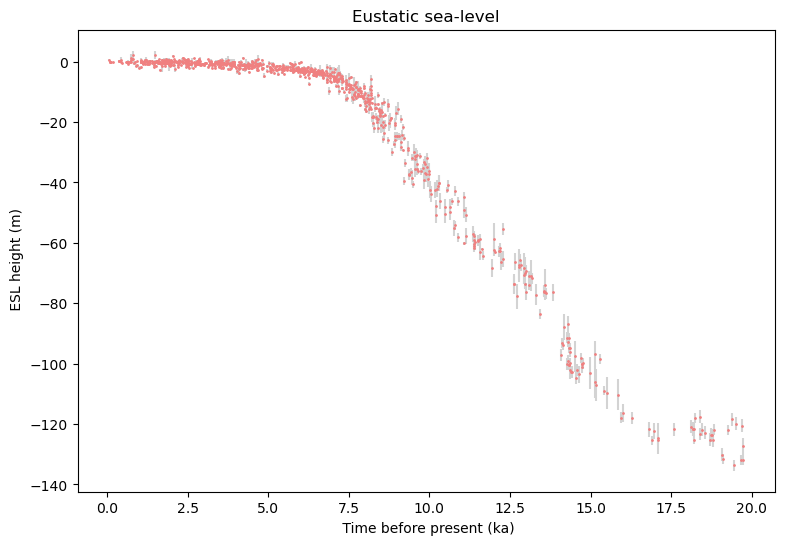

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

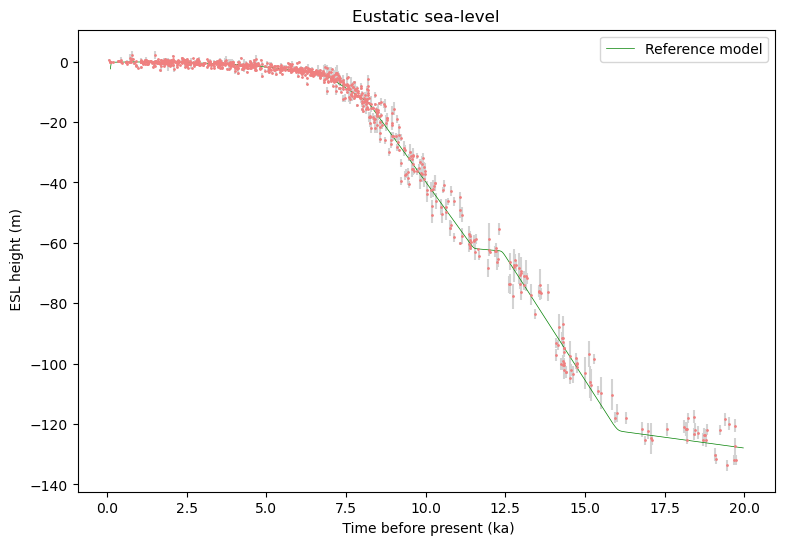

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'optimization', 'matrix solvers', 'sampling'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

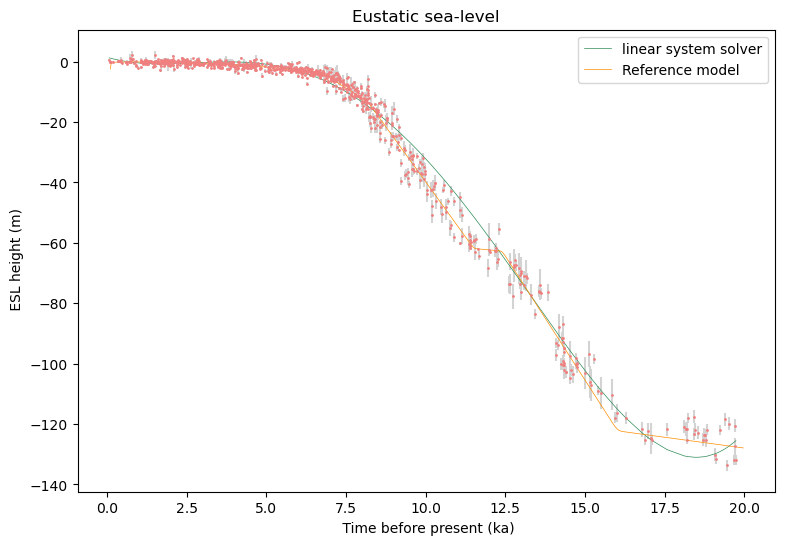

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


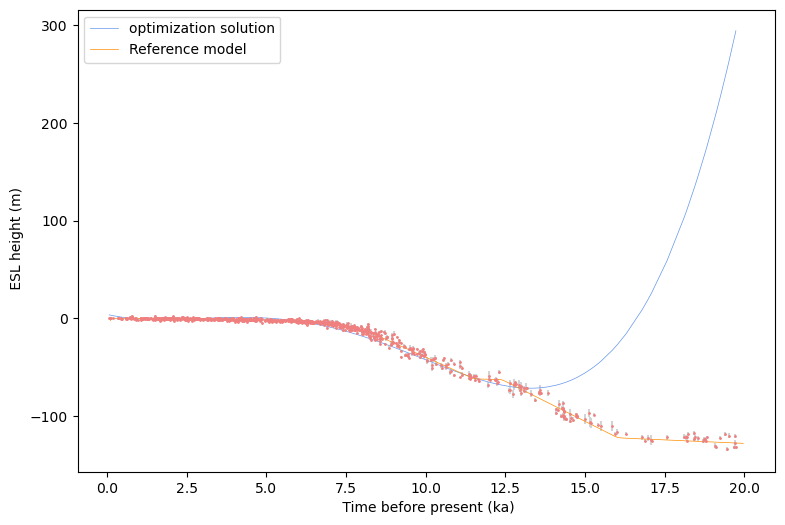

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


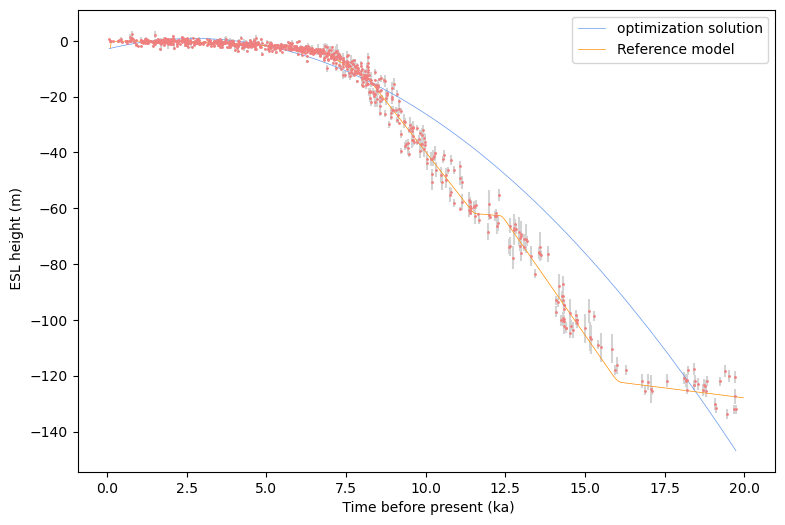

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                                                                                                                        | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                                             | 14/10000 [00:00<01:15, 132.82it/s]

  0%|▋                                                                                                                                                                                                                                                             | 28/10000 [00:00<01:13, 135.40it/s]

  0%|█                                                                                                                                                                                                                                                             | 42/10000 [00:00<01:12, 137.21it/s]

  1%|█▍                                                                                                                                                                                                                                                            | 56/10000 [00:00<01:12, 137.56it/s]

  1%|█▊                                                                                                                                                                                                                                                            | 70/10000 [00:00<01:11, 138.09it/s]

  1%|██▏                                                                                                                                                                                                                                                           | 84/10000 [00:00<01:11, 138.44it/s]

  1%|██▍                                                                                                                                                                                                                                                           | 98/10000 [00:00<01:12, 137.38it/s]

  1%|██▊                                                                                                                                                                                                                                                          | 112/10000 [00:00<01:23, 118.19it/s]

  1%|███▏                                                                                                                                                                                                                                                         | 126/10000 [00:00<01:19, 123.84it/s]

  1%|███▌                                                                                                                                                                                                                                                         | 140/10000 [00:01<01:16, 128.20it/s]

  2%|███▉                                                                                                                                                                                                                                                         | 154/10000 [00:01<01:15, 130.79it/s]

  2%|████▎                                                                                                                                                                                                                                                        | 168/10000 [00:01<01:13, 133.06it/s]

  2%|████▌                                                                                                                                                                                                                                                        | 182/10000 [00:01<01:12, 135.04it/s]

  2%|████▉                                                                                                                                                                                                                                                        | 196/10000 [00:01<01:11, 136.32it/s]

  2%|█████▎                                                                                                                                                                                                                                                       | 210/10000 [00:01<01:11, 137.37it/s]

  2%|█████▋                                                                                                                                                                                                                                                       | 225/10000 [00:01<01:10, 138.21it/s]

  2%|██████                                                                                                                                                                                                                                                       | 240/10000 [00:01<01:10, 138.82it/s]

  3%|██████▍                                                                                                                                                                                                                                                      | 254/10000 [00:01<01:11, 137.16it/s]

  3%|██████▊                                                                                                                                                                                                                                                      | 268/10000 [00:01<01:10, 137.91it/s]

  3%|███████▏                                                                                                                                                                                                                                                     | 282/10000 [00:02<01:11, 136.55it/s]

  3%|███████▍                                                                                                                                                                                                                                                     | 296/10000 [00:02<01:12, 134.53it/s]

  3%|███████▊                                                                                                                                                                                                                                                     | 310/10000 [00:02<01:11, 135.83it/s]

  3%|████████▏                                                                                                                                                                                                                                                    | 324/10000 [00:02<01:10, 136.87it/s]

  3%|████████▌                                                                                                                                                                                                                                                    | 338/10000 [00:02<01:10, 137.67it/s]

  4%|████████▉                                                                                                                                                                                                                                                    | 352/10000 [00:02<01:09, 138.13it/s]

  4%|█████████▎                                                                                                                                                                                                                                                   | 367/10000 [00:02<01:09, 138.81it/s]

  4%|█████████▋                                                                                                                                                                                                                                                   | 382/10000 [00:02<01:09, 139.32it/s]

  4%|██████████                                                                                                                                                                                                                                                   | 397/10000 [00:02<01:08, 139.70it/s]

  4%|██████████▍                                                                                                                                                                                                                                                  | 412/10000 [00:03<01:08, 139.98it/s]

  4%|██████████▊                                                                                                                                                                                                                                                  | 427/10000 [00:03<01:08, 140.14it/s]

  4%|███████████▏                                                                                                                                                                                                                                                 | 442/10000 [00:03<01:08, 140.13it/s]

  5%|███████████▌                                                                                                                                                                                                                                                 | 457/10000 [00:03<01:08, 140.27it/s]

  5%|███████████▉                                                                                                                                                                                                                                                 | 472/10000 [00:03<01:07, 140.29it/s]

  5%|████████████▎                                                                                                                                                                                                                                                | 487/10000 [00:03<01:07, 140.36it/s]

  5%|████████████▋                                                                                                                                                                                                                                                | 502/10000 [00:03<01:07, 140.28it/s]

  5%|█████████████                                                                                                                                                                                                                                                | 517/10000 [00:03<01:07, 140.29it/s]

  5%|█████████████▍                                                                                                                                                                                                                                               | 532/10000 [00:03<01:07, 140.30it/s]

  5%|█████████████▊                                                                                                                                                                                                                                               | 547/10000 [00:03<01:07, 140.36it/s]

  6%|██████████████▏                                                                                                                                                                                                                                              | 562/10000 [00:04<01:07, 140.38it/s]

  6%|██████████████▌                                                                                                                                                                                                                                              | 577/10000 [00:04<01:07, 139.09it/s]

  6%|██████████████▉                                                                                                                                                                                                                                              | 591/10000 [00:04<01:07, 138.41it/s]

  6%|███████████████▎                                                                                                                                                                                                                                             | 605/10000 [00:04<01:07, 138.78it/s]

  6%|███████████████▋                                                                                                                                                                                                                                             | 619/10000 [00:04<01:07, 139.12it/s]

  6%|████████████████                                                                                                                                                                                                                                             | 634/10000 [00:04<01:07, 139.55it/s]

  6%|████████████████▍                                                                                                                                                                                                                                            | 649/10000 [00:04<01:06, 139.82it/s]

  7%|████████████████▊                                                                                                                                                                                                                                            | 664/10000 [00:04<01:06, 140.15it/s]

  7%|█████████████████▏                                                                                                                                                                                                                                           | 679/10000 [00:04<01:06, 139.63it/s]

  7%|█████████████████▌                                                                                                                                                                                                                                           | 693/10000 [00:05<01:07, 137.99it/s]

  7%|█████████████████▉                                                                                                                                                                                                                                           | 708/10000 [00:05<01:06, 138.69it/s]

  7%|██████████████████▎                                                                                                                                                                                                                                          | 723/10000 [00:05<01:06, 139.28it/s]

  7%|██████████████████▋                                                                                                                                                                                                                                          | 738/10000 [00:05<01:06, 139.71it/s]

  8%|███████████████████                                                                                                                                                                                                                                          | 752/10000 [00:05<01:06, 139.70it/s]

  8%|███████████████████▍                                                                                                                                                                                                                                         | 766/10000 [00:05<01:06, 139.29it/s]

  8%|███████████████████▊                                                                                                                                                                                                                                         | 781/10000 [00:05<01:06, 139.61it/s]

  8%|████████████████████                                                                                                                                                                                                                                         | 795/10000 [00:05<01:05, 139.70it/s]

  8%|████████████████████▍                                                                                                                                                                                                                                        | 810/10000 [00:05<01:05, 139.90it/s]

  8%|████████████████████▊                                                                                                                                                                                                                                        | 825/10000 [00:05<01:05, 140.08it/s]

  8%|█████████████████████▎                                                                                                                                                                                                                                       | 840/10000 [00:06<01:05, 140.20it/s]

  9%|█████████████████████▋                                                                                                                                                                                                                                       | 855/10000 [00:06<01:05, 140.20it/s]

  9%|██████████████████████                                                                                                                                                                                                                                       | 870/10000 [00:06<01:05, 140.27it/s]

  9%|██████████████████████▍                                                                                                                                                                                                                                      | 885/10000 [00:06<01:05, 139.87it/s]

  9%|██████████████████████▋                                                                                                                                                                                                                                      | 899/10000 [00:06<01:05, 139.58it/s]

  9%|███████████████████████                                                                                                                                                                                                                                      | 914/10000 [00:06<01:04, 139.82it/s]

  9%|███████████████████████▌                                                                                                                                                                                                                                     | 929/10000 [00:06<01:04, 140.01it/s]

  9%|███████████████████████▉                                                                                                                                                                                                                                     | 944/10000 [00:06<01:04, 140.14it/s]

 10%|████████████████████████▎                                                                                                                                                                                                                                    | 959/10000 [00:06<01:04, 140.24it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                                    | 974/10000 [00:07<01:04, 140.32it/s]

 10%|█████████████████████████                                                                                                                                                                                                                                    | 989/10000 [00:07<01:04, 140.37it/s]

 10%|█████████████████████████▎                                                                                                                                                                                                                                  | 1004/10000 [00:07<01:04, 140.32it/s]

 10%|█████████████████████████▋                                                                                                                                                                                                                                  | 1019/10000 [00:07<01:03, 140.34it/s]

 10%|██████████████████████████                                                                                                                                                                                                                                  | 1034/10000 [00:07<01:03, 140.21it/s]

 10%|██████████████████████████▍                                                                                                                                                                                                                                 | 1049/10000 [00:07<01:03, 140.33it/s]

 11%|██████████████████████████▊                                                                                                                                                                                                                                 | 1064/10000 [00:07<01:03, 140.39it/s]

 11%|███████████████████████████▏                                                                                                                                                                                                                                | 1079/10000 [00:07<01:03, 140.44it/s]

 11%|███████████████████████████▌                                                                                                                                                                                                                                | 1094/10000 [00:07<01:03, 140.54it/s]

 11%|███████████████████████████▉                                                                                                                                                                                                                                | 1109/10000 [00:08<01:04, 138.91it/s]

 11%|████████████████████████████▎                                                                                                                                                                                                                               | 1123/10000 [00:08<01:03, 139.22it/s]

 11%|████████████████████████████▋                                                                                                                                                                                                                               | 1137/10000 [00:08<01:03, 139.22it/s]

 12%|█████████████████████████████                                                                                                                                                                                                                               | 1152/10000 [00:08<01:03, 139.64it/s]

 12%|█████████████████████████████▍                                                                                                                                                                                                                              | 1167/10000 [00:08<01:03, 139.79it/s]

 12%|█████████████████████████████▊                                                                                                                                                                                                                              | 1181/10000 [00:08<01:03, 139.84it/s]

 12%|██████████████████████████████▏                                                                                                                                                                                                                             | 1196/10000 [00:08<01:02, 140.03it/s]

 12%|██████████████████████████████▌                                                                                                                                                                                                                             | 1211/10000 [00:08<01:02, 140.07it/s]

 12%|██████████████████████████████▉                                                                                                                                                                                                                             | 1226/10000 [00:08<01:02, 140.11it/s]

 12%|███████████████████████████████▎                                                                                                                                                                                                                            | 1241/10000 [00:08<01:02, 140.11it/s]

 13%|███████████████████████████████▋                                                                                                                                                                                                                            | 1256/10000 [00:09<01:02, 140.21it/s]

 13%|████████████████████████████████                                                                                                                                                                                                                            | 1271/10000 [00:09<01:02, 138.70it/s]

 13%|████████████████████████████████▍                                                                                                                                                                                                                           | 1285/10000 [00:09<01:02, 138.93it/s]

 13%|████████████████████████████████▊                                                                                                                                                                                                                           | 1300/10000 [00:09<01:02, 139.23it/s]

 13%|█████████████████████████████████▏                                                                                                                                                                                                                          | 1315/10000 [00:09<01:02, 139.58it/s]

 13%|█████████████████████████████████▌                                                                                                                                                                                                                          | 1330/10000 [00:09<01:02, 139.83it/s]

 13%|█████████████████████████████████▉                                                                                                                                                                                                                          | 1345/10000 [00:09<01:01, 139.98it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 1360/10000 [00:09<01:01, 140.15it/s]

 14%|██████████████████████████████████▋                                                                                                                                                                                                                         | 1375/10000 [00:09<01:01, 140.22it/s]

 14%|███████████████████████████████████                                                                                                                                                                                                                         | 1390/10000 [00:10<01:01, 140.21it/s]

 14%|███████████████████████████████████▍                                                                                                                                                                                                                        | 1405/10000 [00:10<01:01, 140.25it/s]

 14%|███████████████████████████████████▊                                                                                                                                                                                                                        | 1420/10000 [00:10<01:01, 140.33it/s]

 14%|████████████████████████████████████▏                                                                                                                                                                                                                       | 1435/10000 [00:10<01:00, 140.47it/s]

 14%|████████████████████████████████████▌                                                                                                                                                                                                                       | 1450/10000 [00:10<01:00, 140.47it/s]

 15%|████████████████████████████████████▉                                                                                                                                                                                                                       | 1465/10000 [00:10<01:00, 140.57it/s]

 15%|█████████████████████████████████████▎                                                                                                                                                                                                                      | 1480/10000 [00:10<01:00, 140.51it/s]

 15%|█████████████████████████████████████▋                                                                                                                                                                                                                      | 1495/10000 [00:10<01:00, 140.59it/s]

 15%|██████████████████████████████████████                                                                                                                                                                                                                      | 1510/10000 [00:10<01:00, 140.56it/s]

 15%|██████████████████████████████████████▍                                                                                                                                                                                                                     | 1525/10000 [00:10<01:00, 140.53it/s]

 15%|██████████████████████████████████████▊                                                                                                                                                                                                                     | 1540/10000 [00:11<01:01, 138.45it/s]

 16%|███████████████████████████████████████▏                                                                                                                                                                                                                    | 1555/10000 [00:11<01:00, 139.02it/s]

 16%|███████████████████████████████████████▌                                                                                                                                                                                                                    | 1570/10000 [00:11<01:00, 139.44it/s]

 16%|███████████████████████████████████████▉                                                                                                                                                                                                                    | 1585/10000 [00:11<01:00, 139.76it/s]

 16%|████████████████████████████████████████▎                                                                                                                                                                                                                   | 1600/10000 [00:11<01:00, 139.89it/s]

 16%|████████████████████████████████████████▋                                                                                                                                                                                                                   | 1615/10000 [00:11<00:59, 140.06it/s]

 16%|█████████████████████████████████████████                                                                                                                                                                                                                   | 1630/10000 [00:11<00:59, 140.26it/s]

 16%|█████████████████████████████████████████▍                                                                                                                                                                                                                  | 1645/10000 [00:11<00:59, 140.37it/s]

 17%|█████████████████████████████████████████▊                                                                                                                                                                                                                  | 1660/10000 [00:11<00:59, 140.37it/s]

 17%|██████████████████████████████████████████▏                                                                                                                                                                                                                 | 1675/10000 [00:12<00:59, 140.18it/s]

 17%|██████████████████████████████████████████▌                                                                                                                                                                                                                 | 1690/10000 [00:12<00:59, 140.21it/s]

 17%|██████████████████████████████████████████▉                                                                                                                                                                                                                 | 1705/10000 [00:12<00:59, 140.32it/s]

 17%|███████████████████████████████████████████▎                                                                                                                                                                                                                | 1720/10000 [00:12<00:58, 140.36it/s]

 17%|███████████████████████████████████████████▋                                                                                                                                                                                                                | 1735/10000 [00:12<00:58, 140.36it/s]

 18%|████████████████████████████████████████████                                                                                                                                                                                                                | 1750/10000 [00:12<00:58, 140.40it/s]

 18%|████████████████████████████████████████████▍                                                                                                                                                                                                               | 1765/10000 [00:12<00:58, 140.43it/s]

 18%|████████████████████████████████████████████▊                                                                                                                                                                                                               | 1780/10000 [00:12<00:58, 140.44it/s]

 18%|█████████████████████████████████████████████▏                                                                                                                                                                                                              | 1795/10000 [00:12<00:58, 140.12it/s]

 18%|█████████████████████████████████████████████▌                                                                                                                                                                                                              | 1810/10000 [00:13<00:58, 140.07it/s]

 18%|█████████████████████████████████████████████▉                                                                                                                                                                                                              | 1825/10000 [00:13<00:58, 140.23it/s]

 18%|██████████████████████████████████████████████▎                                                                                                                                                                                                             | 1840/10000 [00:13<00:58, 140.42it/s]

 19%|██████████████████████████████████████████████▋                                                                                                                                                                                                             | 1855/10000 [00:13<00:57, 140.53it/s]

 19%|███████████████████████████████████████████████                                                                                                                                                                                                             | 1870/10000 [00:13<00:57, 140.58it/s]

 19%|███████████████████████████████████████████████▌                                                                                                                                                                                                            | 1885/10000 [00:13<00:57, 140.62it/s]

 19%|███████████████████████████████████████████████▉                                                                                                                                                                                                            | 1900/10000 [00:13<00:57, 140.67it/s]

 19%|████████████████████████████████████████████████▎                                                                                                                                                                                                           | 1915/10000 [00:13<00:57, 140.76it/s]

 19%|████████████████████████████████████████████████▋                                                                                                                                                                                                           | 1930/10000 [00:13<00:57, 140.84it/s]

 19%|█████████████████████████████████████████████████                                                                                                                                                                                                           | 1945/10000 [00:13<00:57, 140.87it/s]

 20%|█████████████████████████████████████████████████▍                                                                                                                                                                                                          | 1960/10000 [00:14<00:57, 138.81it/s]

 20%|█████████████████████████████████████████████████▋                                                                                                                                                                                                          | 1974/10000 [00:14<00:58, 138.20it/s]

 20%|██████████████████████████████████████████████████                                                                                                                                                                                                          | 1988/10000 [00:14<00:57, 138.68it/s]

 20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                         | 2003/10000 [00:14<00:57, 139.14it/s]

 20%|██████████████████████████████████████████████████▊                                                                                                                                                                                                         | 2017/10000 [00:14<00:57, 138.40it/s]

 20%|███████████████████████████████████████████████████▏                                                                                                                                                                                                        | 2032/10000 [00:14<00:57, 139.01it/s]

 20%|███████████████████████████████████████████████████▌                                                                                                                                                                                                        | 2047/10000 [00:14<00:57, 139.52it/s]

 21%|███████████████████████████████████████████████████▉                                                                                                                                                                                                        | 2062/10000 [00:14<00:56, 139.90it/s]

 21%|████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 2077/10000 [00:14<00:56, 140.02it/s]

 21%|████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 2092/10000 [00:15<00:56, 140.03it/s]

 21%|█████████████████████████████████████████████████████                                                                                                                                                                                                       | 2107/10000 [00:15<00:56, 140.07it/s]

 21%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                      | 2122/10000 [00:15<00:56, 140.18it/s]

 21%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 2137/10000 [00:15<00:56, 140.35it/s]

 22%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                     | 2152/10000 [00:15<00:56, 140.13it/s]

 22%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 2167/10000 [00:15<00:56, 139.73it/s]

 22%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 2182/10000 [00:15<00:55, 139.95it/s]

 22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                    | 2197/10000 [00:15<00:55, 140.19it/s]

 22%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2212/10000 [00:15<00:55, 140.36it/s]

 22%|████████████████████████████████████████████████████████                                                                                                                                                                                                    | 2227/10000 [00:16<00:55, 140.48it/s]

 22%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 2242/10000 [00:16<00:55, 140.54it/s]

 23%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 2257/10000 [00:16<00:55, 140.61it/s]

 23%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                  | 2272/10000 [00:16<00:54, 140.62it/s]

 23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 2287/10000 [00:16<00:54, 140.67it/s]

 23%|██████████████████████████████████████████████████████████                                                                                                                                                                                                  | 2302/10000 [00:16<00:54, 140.33it/s]

 23%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 2317/10000 [00:16<00:54, 140.49it/s]

 23%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 2332/10000 [00:16<00:54, 140.57it/s]

 23%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 2347/10000 [00:16<00:54, 140.58it/s]

 24%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 2362/10000 [00:16<00:55, 138.67it/s]

 24%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                                | 2376/10000 [00:17<00:55, 137.25it/s]

 24%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 2391/10000 [00:17<00:55, 138.21it/s]

 24%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                               | 2406/10000 [00:17<00:54, 139.07it/s]

 24%|█████████████████████████████████████████████████████████████                                                                                                                                                                                               | 2421/10000 [00:17<00:54, 139.63it/s]

 24%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 2435/10000 [00:17<00:58, 128.31it/s]

 24%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2448/10000 [00:17<01:01, 122.52it/s]

 25%|██████████████████████████████████████████████████████████████                                                                                                                                                                                              | 2462/10000 [00:17<00:59, 127.25it/s]

 25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 2477/10000 [00:17<00:57, 131.23it/s]

 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 2492/10000 [00:17<00:56, 134.04it/s]

 25%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 2507/10000 [00:18<00:55, 135.90it/s]

 25%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 2521/10000 [00:18<00:54, 136.51it/s]

 25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                            | 2535/10000 [00:18<00:54, 137.11it/s]

 26%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 2550/10000 [00:18<00:53, 138.21it/s]

 26%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                           | 2565/10000 [00:18<00:53, 138.85it/s]

 26%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 2579/10000 [00:18<00:54, 137.16it/s]

 26%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 2594/10000 [00:18<00:53, 138.14it/s]

 26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 2609/10000 [00:18<00:53, 138.87it/s]

 26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 2624/10000 [00:18<00:52, 139.39it/s]

 26%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                                         | 2639/10000 [00:19<00:52, 139.67it/s]

 27%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 2654/10000 [00:19<00:52, 139.93it/s]

 27%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 2668/10000 [00:19<00:52, 139.02it/s]

 27%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 2683/10000 [00:19<00:52, 139.47it/s]

 27%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 2698/10000 [00:19<00:52, 139.68it/s]

 27%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                       | 2713/10000 [00:19<00:52, 139.83it/s]

 27%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 2728/10000 [00:19<00:51, 140.04it/s]

 27%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 2743/10000 [00:19<00:51, 140.17it/s]

 28%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 2758/10000 [00:19<00:51, 140.25it/s]

 28%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 2773/10000 [00:19<00:51, 139.91it/s]

 28%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                     | 2787/10000 [00:20<00:52, 138.12it/s]

 28%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 2801/10000 [00:20<00:51, 138.66it/s]

 28%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 2816/10000 [00:20<00:51, 139.26it/s]

 28%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 2831/10000 [00:20<00:51, 139.59it/s]

 28%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 2846/10000 [00:20<00:51, 139.86it/s]

 29%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 2861/10000 [00:20<00:50, 140.07it/s]

 29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 2876/10000 [00:20<00:50, 140.21it/s]

 29%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 2891/10000 [00:20<00:50, 140.31it/s]

 29%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 2906/10000 [00:20<00:50, 140.34it/s]

 29%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 2921/10000 [00:21<00:50, 140.41it/s]

 29%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 2936/10000 [00:21<00:50, 140.42it/s]

 30%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 2951/10000 [00:21<00:50, 140.45it/s]

 30%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                 | 2966/10000 [00:21<00:50, 140.48it/s]

 30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 2981/10000 [00:21<00:49, 140.42it/s]

 30%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 2996/10000 [00:21<00:49, 140.32it/s]

 30%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 3011/10000 [00:21<00:49, 140.03it/s]

 30%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 3026/10000 [00:21<00:49, 139.90it/s]

 30%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 3041/10000 [00:21<00:49, 140.08it/s]

 31%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                               | 3056/10000 [00:21<00:49, 140.18it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 3071/10000 [00:22<00:49, 140.20it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 3086/10000 [00:22<00:49, 138.36it/s]

 31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 3100/10000 [00:22<00:49, 138.67it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 3114/10000 [00:22<00:49, 138.79it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 3128/10000 [00:22<00:49, 139.04it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 3142/10000 [00:22<00:49, 139.12it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 3156/10000 [00:22<00:49, 139.32it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 3170/10000 [00:22<00:48, 139.49it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 3184/10000 [00:22<00:48, 139.60it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 3198/10000 [00:23<00:49, 137.76it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 3212/10000 [00:23<00:49, 138.41it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 3227/10000 [00:23<00:48, 139.01it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 3242/10000 [00:23<00:48, 139.48it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 3257/10000 [00:23<00:48, 139.70it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 3272/10000 [00:23<00:48, 139.93it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 3287/10000 [00:23<00:47, 140.16it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 3302/10000 [00:23<00:47, 140.17it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 3317/10000 [00:23<00:47, 140.28it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 3332/10000 [00:23<00:47, 140.37it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 3347/10000 [00:24<00:47, 140.34it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 3362/10000 [00:24<00:47, 139.37it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 3377/10000 [00:24<00:47, 139.64it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 3392/10000 [00:24<00:47, 139.67it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 3407/10000 [00:24<00:47, 139.86it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 3422/10000 [00:24<00:46, 140.08it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 3437/10000 [00:24<00:46, 140.21it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 3452/10000 [00:24<00:46, 140.29it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 3467/10000 [00:24<00:46, 140.31it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 3482/10000 [00:25<00:46, 140.23it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 3497/10000 [00:25<00:46, 140.34it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 3512/10000 [00:25<00:46, 140.32it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 3527/10000 [00:25<00:46, 140.34it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 3542/10000 [00:25<00:46, 140.30it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 3557/10000 [00:25<00:46, 139.53it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 3571/10000 [00:25<00:46, 137.75it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 3586/10000 [00:25<00:46, 138.55it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 3600/10000 [00:25<00:46, 138.95it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 3615/10000 [00:25<00:45, 139.38it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 3629/10000 [00:26<00:46, 137.64it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 3643/10000 [00:26<00:46, 136.63it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 3658/10000 [00:26<00:46, 137.81it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 3673/10000 [00:26<00:45, 138.59it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 3687/10000 [00:26<00:45, 137.91it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 3702/10000 [00:26<00:45, 138.67it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 3717/10000 [00:26<00:45, 139.15it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 3731/10000 [00:26<00:44, 139.39it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 3746/10000 [00:26<00:44, 139.77it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 3761/10000 [00:27<00:44, 139.96it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 3776/10000 [00:27<00:44, 140.05it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 3791/10000 [00:27<00:44, 139.97it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 3806/10000 [00:27<00:44, 140.09it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 3821/10000 [00:27<00:44, 140.14it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 3836/10000 [00:27<00:43, 140.29it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 3851/10000 [00:27<00:43, 140.32it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 3866/10000 [00:27<00:43, 140.32it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 3881/10000 [00:27<00:43, 140.41it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 3896/10000 [00:28<00:43, 140.41it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 3911/10000 [00:28<00:43, 140.42it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 3926/10000 [00:28<00:43, 140.15it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 3941/10000 [00:28<00:43, 140.23it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 3956/10000 [00:28<00:43, 140.26it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 3971/10000 [00:28<00:43, 140.14it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 3986/10000 [00:28<00:42, 140.25it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 4001/10000 [00:28<00:42, 140.26it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 4016/10000 [00:28<00:42, 140.36it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 4031/10000 [00:28<00:42, 140.33it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 4046/10000 [00:29<00:43, 138.37it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 4060/10000 [00:29<00:43, 137.86it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 4075/10000 [00:29<00:42, 138.63it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 4090/10000 [00:29<00:42, 139.15it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 4105/10000 [00:29<00:42, 139.46it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 4120/10000 [00:29<00:42, 139.71it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 4135/10000 [00:29<00:41, 139.99it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 4150/10000 [00:29<00:41, 140.11it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 4165/10000 [00:29<00:46, 125.43it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 4179/10000 [00:30<00:45, 129.03it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 4194/10000 [00:30<00:43, 132.35it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 4209/10000 [00:30<00:42, 134.72it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 4224/10000 [00:30<00:42, 136.33it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 4239/10000 [00:30<00:41, 137.52it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 4254/10000 [00:30<00:41, 138.36it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 4269/10000 [00:30<00:41, 139.00it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 4284/10000 [00:30<00:40, 139.47it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 4299/10000 [00:30<00:40, 139.72it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 4314/10000 [00:31<00:40, 140.01it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 4329/10000 [00:31<00:40, 140.17it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 4344/10000 [00:31<00:40, 139.72it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 4359/10000 [00:31<00:40, 139.97it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 4374/10000 [00:31<00:40, 140.12it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 4389/10000 [00:31<00:40, 140.22it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 4404/10000 [00:31<00:39, 140.26it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 4419/10000 [00:31<00:39, 140.37it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 4434/10000 [00:31<00:39, 140.32it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 4449/10000 [00:32<00:39, 140.28it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 4464/10000 [00:32<00:40, 138.27it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 4478/10000 [00:32<00:39, 138.71it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 4493/10000 [00:32<00:39, 139.20it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 4508/10000 [00:32<00:39, 139.46it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 4522/10000 [00:32<00:39, 139.05it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 4536/10000 [00:32<00:39, 139.12it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 4551/10000 [00:32<00:39, 139.49it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 4566/10000 [00:32<00:38, 139.75it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 4581/10000 [00:32<00:38, 139.96it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 4596/10000 [00:33<00:38, 140.12it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 4611/10000 [00:33<00:38, 139.79it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 4626/10000 [00:33<00:38, 139.98it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 4641/10000 [00:33<00:38, 140.14it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 4656/10000 [00:33<00:38, 140.22it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 4671/10000 [00:33<00:37, 140.31it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 4686/10000 [00:33<00:37, 140.45it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 4701/10000 [00:33<00:37, 140.51it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 4716/10000 [00:33<00:37, 140.52it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 4731/10000 [00:34<00:37, 140.44it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 4746/10000 [00:34<00:37, 140.50it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 4761/10000 [00:34<00:37, 139.59it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 4776/10000 [00:34<00:37, 139.89it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 4791/10000 [00:34<00:37, 140.08it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 4806/10000 [00:34<00:37, 140.12it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 4821/10000 [00:34<00:36, 140.29it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 4836/10000 [00:34<00:36, 140.35it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 4851/10000 [00:34<00:36, 140.43it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 4866/10000 [00:34<00:36, 140.40it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 4881/10000 [00:35<00:36, 138.40it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 4895/10000 [00:35<00:36, 138.22it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 4910/10000 [00:35<00:36, 138.94it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 4924/10000 [00:35<00:36, 139.23it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 4939/10000 [00:35<00:36, 139.64it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 4953/10000 [00:35<00:36, 138.99it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 4967/10000 [00:35<00:36, 139.09it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 4981/10000 [00:35<00:36, 139.26it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 4996/10000 [00:35<00:35, 139.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 5011/10000 [00:36<00:35, 139.96it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 5025/10000 [00:36<00:36, 135.56it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 5039/10000 [00:36<00:36, 136.79it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 5054/10000 [00:36<00:35, 137.98it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 5069/10000 [00:36<00:35, 138.67it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 5084/10000 [00:36<00:35, 139.25it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 5099/10000 [00:36<00:35, 139.61it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 5114/10000 [00:36<00:34, 139.95it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 5129/10000 [00:36<00:34, 140.06it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 5144/10000 [00:36<00:34, 140.23it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 5159/10000 [00:37<00:34, 140.34it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 5174/10000 [00:37<00:34, 140.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 5189/10000 [00:37<00:34, 140.44it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 5204/10000 [00:37<00:34, 140.27it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 5219/10000 [00:37<00:34, 140.26it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 5234/10000 [00:37<00:33, 140.37it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 5249/10000 [00:37<00:33, 140.49it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 5264/10000 [00:37<00:33, 140.34it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 5279/10000 [00:37<00:33, 140.43it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 5294/10000 [00:38<00:34, 138.37it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 5309/10000 [00:38<00:33, 138.98it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 5323/10000 [00:38<00:33, 139.09it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 5338/10000 [00:38<00:33, 139.63it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 5353/10000 [00:38<00:33, 139.91it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 5368/10000 [00:38<00:33, 140.05it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 5383/10000 [00:38<00:32, 140.24it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 5398/10000 [00:38<00:32, 140.37it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 5413/10000 [00:38<00:32, 140.43it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 5428/10000 [00:39<00:32, 140.46it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 5443/10000 [00:39<00:32, 140.36it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 5458/10000 [00:39<00:32, 139.44it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 5473/10000 [00:39<00:32, 139.70it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 5487/10000 [00:39<00:32, 139.65it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 5502/10000 [00:39<00:32, 139.90it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 5517/10000 [00:39<00:31, 140.10it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 5532/10000 [00:39<00:31, 140.18it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 5547/10000 [00:39<00:31, 140.33it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 5562/10000 [00:39<00:31, 140.38it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 5577/10000 [00:40<00:31, 140.48it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 5592/10000 [00:40<00:31, 140.55it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 5607/10000 [00:40<00:31, 140.54it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 5622/10000 [00:40<00:31, 140.58it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 5637/10000 [00:40<00:31, 140.60it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 5652/10000 [00:40<00:30, 140.58it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 5667/10000 [00:40<00:30, 140.59it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 5682/10000 [00:40<00:30, 140.62it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 5697/10000 [00:40<00:30, 140.64it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 5712/10000 [00:41<00:30, 138.60it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 5727/10000 [00:41<00:30, 139.16it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 5742/10000 [00:41<00:30, 139.47it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 5757/10000 [00:41<00:30, 139.77it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 5772/10000 [00:41<00:30, 139.98it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 5787/10000 [00:41<00:30, 140.20it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 5802/10000 [00:41<00:29, 140.41it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 5817/10000 [00:41<00:29, 140.45it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 5832/10000 [00:41<00:29, 140.50it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 5847/10000 [00:42<00:29, 140.44it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 5862/10000 [00:42<00:29, 140.52it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 5877/10000 [00:42<00:29, 140.57it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 5892/10000 [00:42<00:29, 140.62it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 5907/10000 [00:42<00:29, 140.20it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 5922/10000 [00:42<00:29, 140.17it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 5937/10000 [00:42<00:28, 140.30it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 5952/10000 [00:42<00:28, 140.30it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 5967/10000 [00:42<00:28, 140.40it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 5982/10000 [00:42<00:28, 140.43it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 5997/10000 [00:43<00:28, 140.49it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 6012/10000 [00:43<00:28, 140.54it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 6027/10000 [00:43<00:28, 140.46it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 6042/10000 [00:43<00:28, 140.54it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 6057/10000 [00:43<00:28, 140.56it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 6072/10000 [00:43<00:27, 140.60it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 6087/10000 [00:43<00:27, 140.67it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 6102/10000 [00:43<00:27, 140.62it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 6117/10000 [00:43<00:27, 140.59it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 6132/10000 [00:44<00:27, 138.23it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 6147/10000 [00:44<00:27, 138.85it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 6161/10000 [00:44<00:27, 138.31it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 6176/10000 [00:44<00:27, 138.97it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 6191/10000 [00:44<00:27, 139.38it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 6206/10000 [00:44<00:27, 139.65it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 6221/10000 [00:44<00:26, 139.98it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 6236/10000 [00:44<00:26, 140.15it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 6251/10000 [00:44<00:26, 140.32it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 6266/10000 [00:44<00:26, 140.43it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 6281/10000 [00:45<00:26, 140.34it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 6296/10000 [00:45<00:26, 140.47it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 6311/10000 [00:45<00:26, 140.49it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 6326/10000 [00:45<00:26, 140.51it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 6341/10000 [00:45<00:26, 140.56it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 6356/10000 [00:45<00:26, 139.79it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 6371/10000 [00:45<00:25, 140.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 6386/10000 [00:45<00:25, 140.21it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 6401/10000 [00:45<00:25, 140.39it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 6416/10000 [00:46<00:25, 140.34it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 6431/10000 [00:46<00:25, 140.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 6446/10000 [00:46<00:25, 140.40it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 6461/10000 [00:46<00:25, 140.50it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 6476/10000 [00:46<00:25, 140.45it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 6491/10000 [00:46<00:24, 140.46it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 6506/10000 [00:46<00:24, 140.49it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 6521/10000 [00:46<00:24, 140.61it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 6536/10000 [00:46<00:24, 140.69it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 6551/10000 [00:47<00:24, 138.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 6566/10000 [00:47<00:24, 139.35it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 6581/10000 [00:47<00:24, 139.83it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 6596/10000 [00:47<00:24, 140.09it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 6611/10000 [00:47<00:24, 140.22it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 6626/10000 [00:47<00:24, 140.35it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 6641/10000 [00:47<00:23, 140.47it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 6656/10000 [00:47<00:23, 140.60it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 6671/10000 [00:47<00:23, 140.62it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 6686/10000 [00:47<00:23, 140.68it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 6701/10000 [00:48<00:23, 140.74it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 6716/10000 [00:48<00:23, 140.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 6731/10000 [00:48<00:23, 140.66it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 6746/10000 [00:48<00:23, 140.73it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 6761/10000 [00:48<00:23, 140.71it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 6776/10000 [00:48<00:22, 140.73it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 6791/10000 [00:48<00:22, 140.70it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 6806/10000 [00:48<00:22, 140.51it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 6821/10000 [00:48<00:22, 140.36it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 6836/10000 [00:49<00:22, 140.52it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 6851/10000 [00:49<00:22, 140.59it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 6866/10000 [00:49<00:22, 139.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 6880/10000 [00:49<00:22, 139.85it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 6895/10000 [00:49<00:22, 140.01it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 6910/10000 [00:49<00:22, 139.92it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 6925/10000 [00:49<00:21, 140.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 6940/10000 [00:49<00:21, 140.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 6955/10000 [00:49<00:21, 140.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 6970/10000 [00:50<00:21, 138.60it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 6985/10000 [00:50<00:21, 139.11it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 7000/10000 [00:50<00:21, 139.48it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 7015/10000 [00:50<00:21, 139.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 7030/10000 [00:50<00:21, 140.06it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 7045/10000 [00:50<00:21, 140.21it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 7060/10000 [00:50<00:20, 140.35it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 7075/10000 [00:50<00:20, 140.44it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 7090/10000 [00:50<00:20, 140.58it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 7105/10000 [00:50<00:20, 140.65it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 7120/10000 [00:51<00:20, 140.65it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 7135/10000 [00:51<00:20, 140.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 7150/10000 [00:51<00:20, 140.69it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 7165/10000 [00:51<00:20, 140.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 7180/10000 [00:51<00:20, 140.29it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 7195/10000 [00:51<00:19, 140.42it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 7210/10000 [00:51<00:19, 140.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 7225/10000 [00:51<00:19, 140.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 7240/10000 [00:51<00:19, 140.66it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 7255/10000 [00:52<00:19, 140.62it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 7270/10000 [00:52<00:19, 140.65it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 7285/10000 [00:52<00:19, 140.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 7300/10000 [00:52<00:19, 140.67it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 7315/10000 [00:52<00:19, 140.54it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 7330/10000 [00:52<00:19, 140.52it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 7345/10000 [00:52<00:18, 140.57it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 7360/10000 [00:52<00:18, 140.68it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 7375/10000 [00:52<00:18, 140.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7390/10000 [00:53<00:18, 140.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7405/10000 [00:53<00:18, 138.83it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 7420/10000 [00:53<00:18, 139.35it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 7435/10000 [00:53<00:18, 139.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 7450/10000 [00:53<00:18, 140.08it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 7465/10000 [00:53<00:18, 140.26it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 7480/10000 [00:53<00:17, 140.40it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 7495/10000 [00:53<00:17, 140.53it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7510/10000 [00:53<00:17, 140.67it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 7525/10000 [00:53<00:17, 140.69it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 7540/10000 [00:54<00:17, 140.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 7555/10000 [00:54<00:17, 139.79it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 7569/10000 [00:54<00:17, 138.39it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 7584/10000 [00:54<00:17, 139.00it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 7599/10000 [00:54<00:17, 139.38it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7614/10000 [00:54<00:17, 139.73it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 7629/10000 [00:54<00:16, 140.07it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 7644/10000 [00:54<00:16, 140.24it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 7659/10000 [00:54<00:16, 140.43it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7674/10000 [00:55<00:16, 140.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7689/10000 [00:55<00:16, 140.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7704/10000 [00:55<00:16, 140.67it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7719/10000 [00:55<00:16, 140.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 7734/10000 [00:55<00:16, 140.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 7749/10000 [00:55<00:16, 140.05it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7764/10000 [00:55<00:15, 140.28it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 7779/10000 [00:55<00:15, 140.41it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 7794/10000 [00:55<00:15, 140.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 7809/10000 [00:55<00:15, 140.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 7824/10000 [00:56<00:15, 138.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 7839/10000 [00:56<00:15, 139.36it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7854/10000 [00:56<00:15, 139.80it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 7869/10000 [00:56<00:15, 140.06it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7884/10000 [00:56<00:15, 140.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7899/10000 [00:56<00:14, 140.29it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 7914/10000 [00:56<00:14, 140.42it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 7929/10000 [00:56<00:14, 139.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 7943/10000 [00:56<00:14, 139.59it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 7958/10000 [00:57<00:14, 139.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 7972/10000 [00:57<00:14, 139.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 7987/10000 [00:57<00:14, 139.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 8001/10000 [00:57<00:14, 139.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 8015/10000 [00:57<00:14, 139.32it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 8030/10000 [00:57<00:14, 139.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 8045/10000 [00:57<00:13, 139.96it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 8060/10000 [00:57<00:13, 140.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8075/10000 [00:57<00:13, 140.42it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 8090/10000 [00:58<00:13, 140.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 8105/10000 [00:58<00:13, 140.67it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 8120/10000 [00:58<00:13, 140.41it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 8135/10000 [00:58<00:13, 140.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 8150/10000 [00:58<00:13, 140.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 8165/10000 [00:58<00:13, 140.72it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 8180/10000 [00:58<00:12, 140.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 8195/10000 [00:58<00:12, 140.73it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 8210/10000 [00:58<00:12, 140.66it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 8225/10000 [00:58<00:12, 140.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8240/10000 [00:59<00:12, 138.97it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 8254/10000 [00:59<00:12, 138.49it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8269/10000 [00:59<00:12, 139.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8284/10000 [00:59<00:12, 139.57it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8299/10000 [00:59<00:12, 139.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 8314/10000 [00:59<00:12, 140.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 8329/10000 [00:59<00:11, 140.29it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 8344/10000 [00:59<00:11, 140.46it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 8359/10000 [00:59<00:11, 140.58it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 8374/10000 [01:00<00:13, 119.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 8388/10000 [01:00<00:12, 124.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 8403/10000 [01:00<00:12, 129.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 8417/10000 [01:00<00:11, 132.03it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8431/10000 [01:00<00:11, 134.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8446/10000 [01:00<00:11, 136.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8461/10000 [01:00<00:11, 137.50it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 8476/10000 [01:00<00:11, 138.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 8491/10000 [01:00<00:10, 139.26it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 8506/10000 [01:01<00:10, 139.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 8521/10000 [01:01<00:10, 140.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 8536/10000 [01:01<00:10, 140.31it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8551/10000 [01:01<00:10, 140.46it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 8566/10000 [01:01<00:10, 140.60it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 8581/10000 [01:01<00:10, 140.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8596/10000 [01:01<00:09, 140.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 8611/10000 [01:01<00:09, 140.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 8626/10000 [01:01<00:09, 140.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 8641/10000 [01:01<00:09, 140.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 8656/10000 [01:02<00:09, 138.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 8671/10000 [01:02<00:09, 139.39it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8686/10000 [01:02<00:09, 139.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8701/10000 [01:02<00:09, 140.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8716/10000 [01:02<00:09, 140.29it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8731/10000 [01:02<00:09, 140.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8746/10000 [01:02<00:08, 140.60it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8761/10000 [01:02<00:08, 140.68it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8776/10000 [01:02<00:08, 140.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 8791/10000 [01:03<00:08, 140.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8806/10000 [01:03<00:08, 140.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8821/10000 [01:03<00:08, 140.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8836/10000 [01:03<00:08, 140.97it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8851/10000 [01:03<00:08, 140.93it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8866/10000 [01:03<00:08, 140.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8881/10000 [01:03<00:07, 140.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8896/10000 [01:03<00:07, 140.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8911/10000 [01:03<00:07, 140.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8926/10000 [01:04<00:07, 140.67it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8941/10000 [01:04<00:07, 140.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8956/10000 [01:04<00:07, 139.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8971/10000 [01:04<00:07, 140.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8986/10000 [01:04<00:07, 140.27it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 9001/10000 [01:04<00:07, 140.27it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 9016/10000 [01:04<00:07, 140.43it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 9031/10000 [01:04<00:06, 140.58it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 9046/10000 [01:04<00:06, 140.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9061/10000 [01:04<00:06, 140.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 9076/10000 [01:05<00:06, 139.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 9090/10000 [01:05<00:06, 139.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 9105/10000 [01:05<00:06, 139.64it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9120/10000 [01:05<00:06, 140.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9135/10000 [01:05<00:06, 140.26it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9150/10000 [01:05<00:06, 139.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9165/10000 [01:05<00:05, 140.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9180/10000 [01:05<00:05, 140.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9195/10000 [01:05<00:05, 140.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9210/10000 [01:06<00:05, 140.65it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 9225/10000 [01:06<00:05, 140.74it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 9240/10000 [01:06<00:05, 140.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9255/10000 [01:06<00:05, 140.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 9270/10000 [01:06<00:05, 140.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 9285/10000 [01:06<00:05, 140.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9300/10000 [01:06<00:04, 140.95it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9315/10000 [01:06<00:04, 141.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9330/10000 [01:06<00:04, 140.93it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9345/10000 [01:07<00:04, 140.93it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9360/10000 [01:07<00:04, 140.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9375/10000 [01:07<00:04, 140.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9390/10000 [01:07<00:04, 140.76it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9405/10000 [01:07<00:04, 140.78it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 9420/10000 [01:07<00:04, 140.74it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9435/10000 [01:07<00:04, 140.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 9450/10000 [01:07<00:03, 140.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9465/10000 [01:07<00:03, 140.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9480/10000 [01:07<00:03, 140.90it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9495/10000 [01:08<00:03, 139.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9510/10000 [01:08<00:03, 139.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9524/10000 [01:08<00:03, 139.71it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9539/10000 [01:08<00:03, 140.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9554/10000 [01:08<00:03, 140.36it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9569/10000 [01:08<00:03, 140.58it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9584/10000 [01:08<00:02, 140.65it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9599/10000 [01:08<00:02, 140.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9614/10000 [01:08<00:02, 140.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9629/10000 [01:09<00:02, 140.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9644/10000 [01:09<00:02, 140.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9659/10000 [01:09<00:02, 139.93it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9674/10000 [01:09<00:02, 140.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9689/10000 [01:09<00:02, 140.33it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9704/10000 [01:09<00:02, 140.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9719/10000 [01:09<00:01, 140.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9734/10000 [01:09<00:01, 140.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9749/10000 [01:09<00:01, 140.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9764/10000 [01:09<00:01, 140.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9779/10000 [01:10<00:01, 140.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9794/10000 [01:10<00:01, 140.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9809/10000 [01:10<00:01, 140.93it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9824/10000 [01:10<00:01, 140.98it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9839/10000 [01:10<00:01, 140.96it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9854/10000 [01:10<00:01, 140.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9869/10000 [01:10<00:00, 140.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9884/10000 [01:10<00:00, 140.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9899/10000 [01:10<00:00, 140.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9914/10000 [01:11<00:00, 139.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9929/10000 [01:11<00:00, 139.57it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9944/10000 [01:11<00:00, 139.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9959/10000 [01:11<00:00, 140.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9974/10000 [01:11<00:00, 138.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9989/10000 [01:11<00:00, 139.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 139.52it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -0.0001065 -0.0001065 ... 1.218 1.219
    m1       (chain, draw) float64 0.0001854 0.0001854 ... -3.015 -3.017
    m2       (chain, draw) float64 -2.037e-05 -2.037e-05 ... 1.434 1.435
    m3       (chain, draw) float64 -1.92e-06 -1.92e-06 ... -0.2157 -0.2159
    m4       (chain, draw) float64 0.0001017 0.0001017 ... 0.00682 0.00683
Attributes:
    created_at:                 2023-02-09T00:11:46.640769
    arviz_version:              0.12.1
    inference_library:          emcee
    inference_library_version:  3.1.2

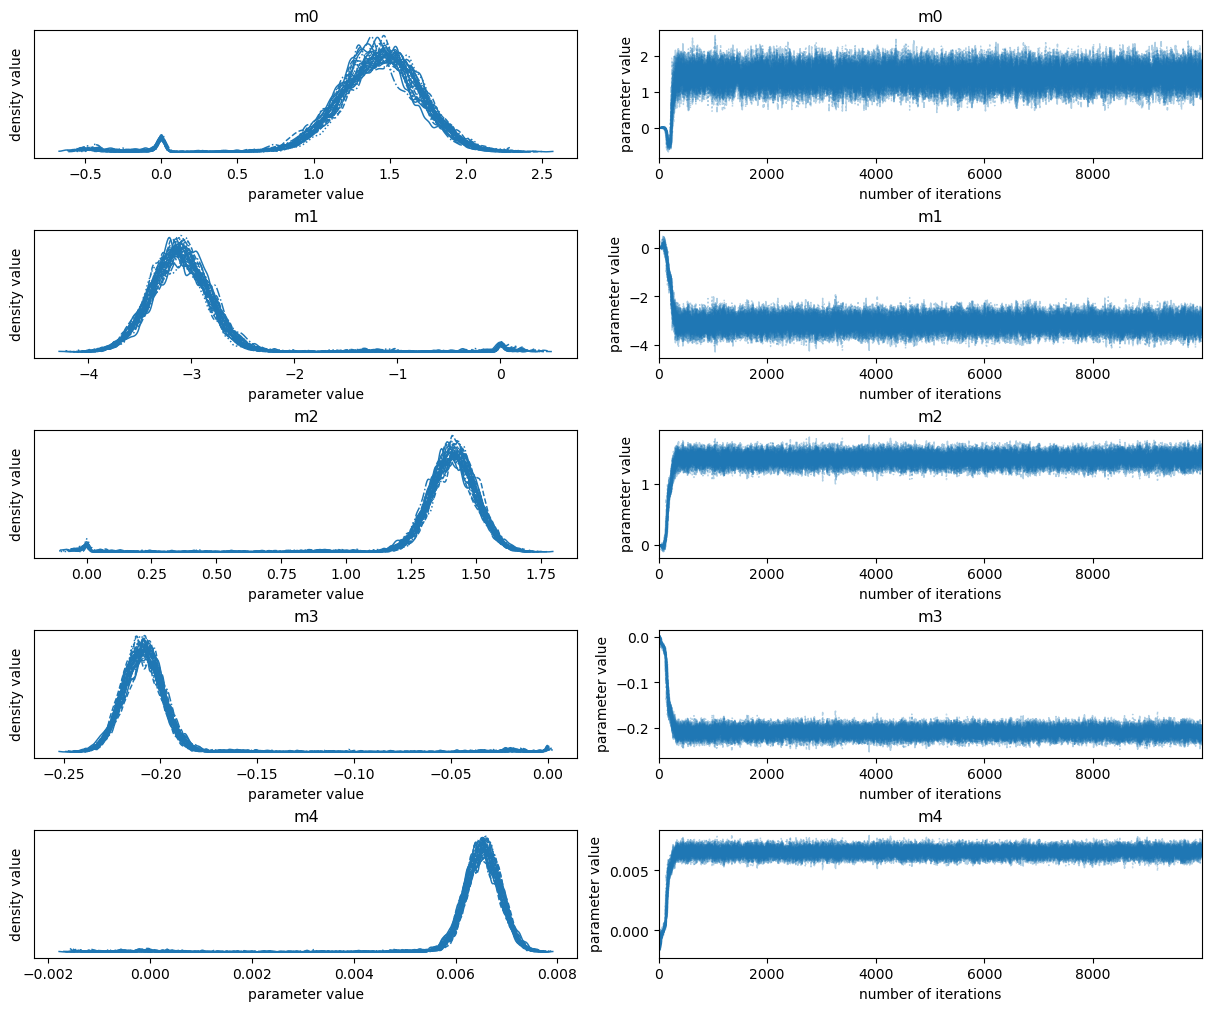

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

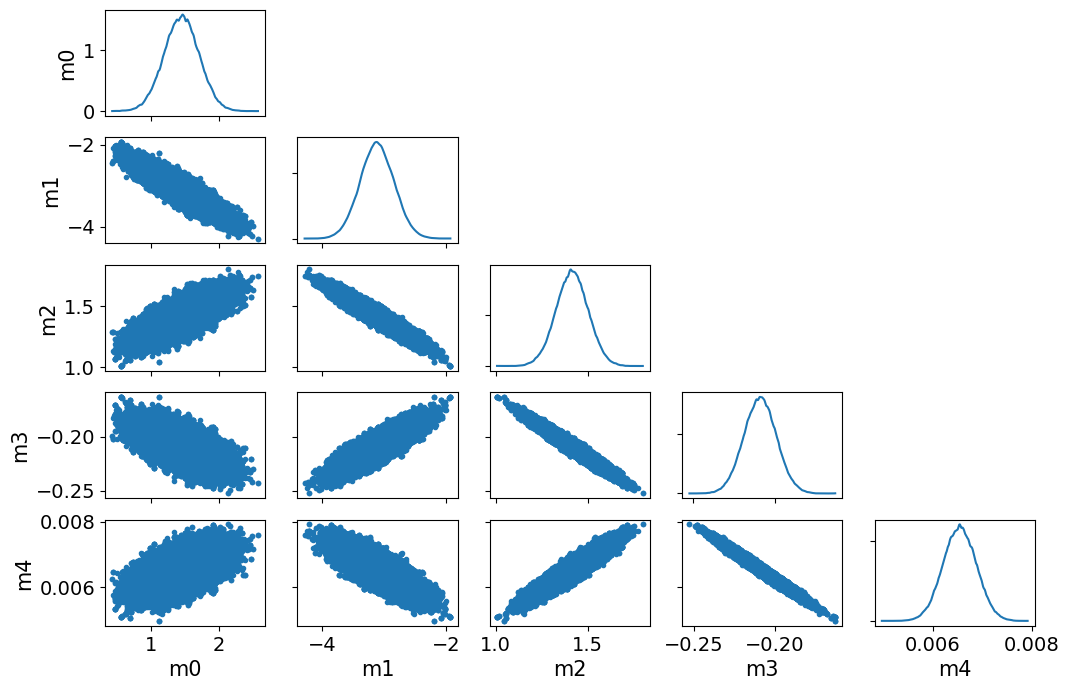

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

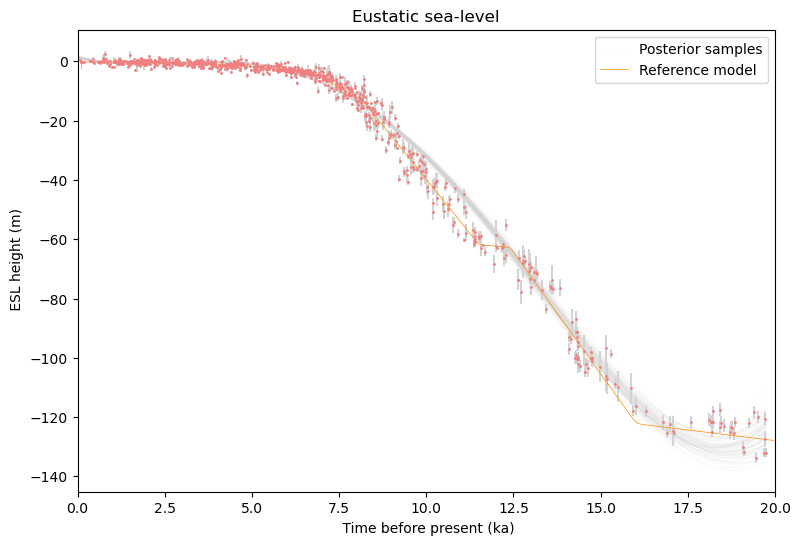

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.445 [  1.021,   1.865]
 m1  -3.118 [ -3.562,  -2.664]
 m2   1.414 [  1.271,   1.552]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.53122647e-02 -6.17882853e-02  1.65078594e-02 -1.58969844e-03
   4.71572107e-05]
 [-6.17882853e-02  7.37887803e-02 -2.22888769e-02  2.32492821e-03
  -7.23381814e-05]
 [ 1.65078594e-02 -2.22888769e-02  7.40825954e-03 -8.27485171e-04
   2.68106915e-05]
 [-1.58969844e-03  2.32492821e-03 -8.27485171e-04  9.74701654e-05
  -3.26337071e-06]
 [ 4.71572107e-05 -7.23381814e-05  2.68106915e-05 -3.26337071e-06
   1.12094354e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2556
    m1  0.2716
    m2  0.0861
    m3  0.0099
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                                                                                                                        | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                                             | 14/10000 [00:00<01:14, 134.87it/s]

  0%|▋                                                                                                                                                                                                                                                             | 28/10000 [00:00<01:14, 133.82it/s]

  0%|█                                                                                                                                                                                                                                                             | 42/10000 [00:00<01:13, 136.40it/s]

  1%|█▍                                                                                                                                                                                                                                                            | 57/10000 [00:00<01:12, 138.01it/s]

  1%|█▊                                                                                                                                                                                                                                                            | 71/10000 [00:00<01:11, 138.65it/s]

  1%|██▏                                                                                                                                                                                                                                                           | 85/10000 [00:00<01:11, 138.65it/s]

  1%|██▌                                                                                                                                                                                                                                                           | 99/10000 [00:00<01:11, 138.98it/s]

  1%|██▉                                                                                                                                                                                                                                                          | 114/10000 [00:00<01:10, 139.39it/s]

  1%|███▏                                                                                                                                                                                                                                                         | 128/10000 [00:00<01:10, 139.51it/s]

  1%|███▌                                                                                                                                                                                                                                                         | 142/10000 [00:01<01:11, 137.53it/s]

  2%|███▉                                                                                                                                                                                                                                                         | 156/10000 [00:01<01:11, 138.24it/s]

  2%|████▎                                                                                                                                                                                                                                                        | 170/10000 [00:01<01:10, 138.72it/s]

  2%|████▋                                                                                                                                                                                                                                                        | 185/10000 [00:01<01:10, 139.27it/s]

  2%|█████                                                                                                                                                                                                                                                        | 199/10000 [00:01<01:10, 138.39it/s]

  2%|█████▍                                                                                                                                                                                                                                                       | 213/10000 [00:01<01:10, 138.84it/s]

  2%|█████▋                                                                                                                                                                                                                                                       | 227/10000 [00:01<01:10, 139.11it/s]

  2%|██████                                                                                                                                                                                                                                                       | 241/10000 [00:01<01:10, 139.27it/s]

  3%|██████▍                                                                                                                                                                                                                                                      | 256/10000 [00:01<01:09, 139.62it/s]

  3%|██████▊                                                                                                                                                                                                                                                      | 271/10000 [00:01<01:09, 139.78it/s]

  3%|███████▏                                                                                                                                                                                                                                                     | 285/10000 [00:02<01:09, 139.69it/s]

  3%|███████▌                                                                                                                                                                                                                                                     | 299/10000 [00:02<01:09, 139.77it/s]

  3%|███████▉                                                                                                                                                                                                                                                     | 314/10000 [00:02<01:09, 139.88it/s]

  3%|████████▎                                                                                                                                                                                                                                                    | 329/10000 [00:02<01:09, 139.94it/s]

  3%|████████▋                                                                                                                                                                                                                                                    | 344/10000 [00:02<01:08, 140.12it/s]

  4%|█████████                                                                                                                                                                                                                                                    | 359/10000 [00:02<01:08, 140.13it/s]

  4%|█████████▍                                                                                                                                                                                                                                                   | 374/10000 [00:02<01:08, 140.04it/s]

  4%|█████████▊                                                                                                                                                                                                                                                   | 389/10000 [00:02<01:08, 139.33it/s]

  4%|██████████▏                                                                                                                                                                                                                                                  | 403/10000 [00:02<01:09, 137.52it/s]

  4%|██████████▌                                                                                                                                                                                                                                                  | 417/10000 [00:03<01:09, 138.22it/s]

  4%|██████████▉                                                                                                                                                                                                                                                  | 431/10000 [00:03<01:08, 138.70it/s]

  4%|███████████▎                                                                                                                                                                                                                                                 | 445/10000 [00:03<01:09, 137.50it/s]

  5%|███████████▌                                                                                                                                                                                                                                                 | 459/10000 [00:03<01:09, 138.20it/s]

  5%|███████████▉                                                                                                                                                                                                                                                 | 473/10000 [00:03<01:09, 137.48it/s]

  5%|████████████▎                                                                                                                                                                                                                                                | 487/10000 [00:03<01:09, 137.77it/s]

  5%|████████████▋                                                                                                                                                                                                                                                | 501/10000 [00:03<01:08, 138.11it/s]

  5%|█████████████                                                                                                                                                                                                                                                | 515/10000 [00:03<01:08, 138.42it/s]

  5%|█████████████▍                                                                                                                                                                                                                                               | 529/10000 [00:03<01:08, 138.38it/s]

  5%|█████████████▋                                                                                                                                                                                                                                               | 543/10000 [00:03<01:08, 138.69it/s]

  6%|██████████████                                                                                                                                                                                                                                               | 557/10000 [00:04<01:07, 138.98it/s]

  6%|██████████████▍                                                                                                                                                                                                                                              | 571/10000 [00:04<01:07, 138.88it/s]

  6%|██████████████▊                                                                                                                                                                                                                                              | 585/10000 [00:04<01:07, 139.06it/s]

  6%|███████████████▏                                                                                                                                                                                                                                             | 599/10000 [00:04<01:07, 139.23it/s]

  6%|███████████████▌                                                                                                                                                                                                                                             | 613/10000 [00:04<01:07, 139.01it/s]

  6%|███████████████▊                                                                                                                                                                                                                                             | 627/10000 [00:04<01:07, 138.22it/s]

  6%|████████████████▏                                                                                                                                                                                                                                            | 641/10000 [00:04<01:10, 132.87it/s]

  7%|████████████████▌                                                                                                                                                                                                                                            | 655/10000 [00:04<01:09, 134.81it/s]

  7%|████████████████▉                                                                                                                                                                                                                                            | 670/10000 [00:04<01:08, 136.48it/s]

  7%|█████████████████▎                                                                                                                                                                                                                                           | 684/10000 [00:04<01:11, 129.66it/s]

  7%|█████████████████▋                                                                                                                                                                                                                                           | 698/10000 [00:05<01:14, 124.53it/s]

  7%|██████████████████                                                                                                                                                                                                                                           | 712/10000 [00:05<01:12, 128.69it/s]

  7%|██████████████████▎                                                                                                                                                                                                                                          | 726/10000 [00:05<01:10, 131.75it/s]

  7%|██████████████████▋                                                                                                                                                                                                                                          | 741/10000 [00:05<01:08, 134.28it/s]

  8%|███████████████████                                                                                                                                                                                                                                          | 755/10000 [00:05<01:08, 135.79it/s]

  8%|███████████████████▍                                                                                                                                                                                                                                         | 770/10000 [00:05<01:07, 137.25it/s]

  8%|███████████████████▊                                                                                                                                                                                                                                         | 784/10000 [00:05<01:06, 137.97it/s]

  8%|████████████████████▏                                                                                                                                                                                                                                        | 799/10000 [00:05<01:06, 138.74it/s]

  8%|████████████████████▌                                                                                                                                                                                                                                        | 814/10000 [00:05<01:05, 139.18it/s]

  8%|████████████████████▉                                                                                                                                                                                                                                        | 828/10000 [00:06<01:06, 138.02it/s]

  8%|█████████████████████▎                                                                                                                                                                                                                                       | 842/10000 [00:06<01:06, 138.43it/s]

  9%|█████████████████████▋                                                                                                                                                                                                                                       | 856/10000 [00:06<01:06, 136.90it/s]

  9%|██████████████████████                                                                                                                                                                                                                                       | 870/10000 [00:06<01:06, 137.69it/s]

  9%|██████████████████████▎                                                                                                                                                                                                                                      | 884/10000 [00:06<01:06, 137.26it/s]

  9%|██████████████████████▋                                                                                                                                                                                                                                      | 898/10000 [00:06<01:06, 137.89it/s]

  9%|███████████████████████                                                                                                                                                                                                                                      | 913/10000 [00:06<01:05, 138.57it/s]

  9%|███████████████████████▍                                                                                                                                                                                                                                     | 927/10000 [00:06<01:05, 138.78it/s]

  9%|███████████████████████▊                                                                                                                                                                                                                                     | 941/10000 [00:06<01:05, 139.14it/s]

 10%|████████████████████████▏                                                                                                                                                                                                                                    | 956/10000 [00:06<01:04, 139.46it/s]

 10%|████████████████████████▌                                                                                                                                                                                                                                    | 970/10000 [00:07<01:04, 139.55it/s]

 10%|████████████████████████▉                                                                                                                                                                                                                                    | 984/10000 [00:07<01:04, 139.61it/s]

 10%|█████████████████████████▏                                                                                                                                                                                                                                   | 998/10000 [00:07<01:04, 139.65it/s]

 10%|█████████████████████████▌                                                                                                                                                                                                                                  | 1012/10000 [00:07<01:04, 139.71it/s]

 10%|█████████████████████████▉                                                                                                                                                                                                                                  | 1027/10000 [00:07<01:04, 139.93it/s]

 10%|██████████████████████████▏                                                                                                                                                                                                                                 | 1041/10000 [00:07<01:04, 139.92it/s]

 11%|██████████████████████████▌                                                                                                                                                                                                                                 | 1055/10000 [00:07<01:03, 139.93it/s]

 11%|██████████████████████████▉                                                                                                                                                                                                                                 | 1069/10000 [00:07<01:03, 139.87it/s]

 11%|███████████████████████████▎                                                                                                                                                                                                                                | 1083/10000 [00:07<01:03, 139.83it/s]

 11%|███████████████████████████▋                                                                                                                                                                                                                                | 1097/10000 [00:07<01:03, 139.78it/s]

 11%|████████████████████████████                                                                                                                                                                                                                                | 1112/10000 [00:08<01:03, 139.90it/s]

 11%|████████████████████████████▍                                                                                                                                                                                                                               | 1127/10000 [00:08<01:03, 139.97it/s]

 11%|████████████████████████████▊                                                                                                                                                                                                                               | 1142/10000 [00:08<01:03, 140.06it/s]

 12%|█████████████████████████████▏                                                                                                                                                                                                                              | 1157/10000 [00:08<01:03, 140.08it/s]

 12%|█████████████████████████████▌                                                                                                                                                                                                                              | 1172/10000 [00:08<01:03, 140.10it/s]

 12%|█████████████████████████████▉                                                                                                                                                                                                                              | 1187/10000 [00:08<01:02, 140.05it/s]

 12%|██████████████████████████████▎                                                                                                                                                                                                                             | 1202/10000 [00:08<01:02, 139.94it/s]

 12%|██████████████████████████████▋                                                                                                                                                                                                                             | 1216/10000 [00:08<01:02, 139.94it/s]

 12%|██████████████████████████████▉                                                                                                                                                                                                                             | 1230/10000 [00:08<01:02, 139.90it/s]

 12%|███████████████████████████████▎                                                                                                                                                                                                                            | 1245/10000 [00:09<01:02, 140.06it/s]

 13%|███████████████████████████████▊                                                                                                                                                                                                                            | 1260/10000 [00:09<01:02, 140.15it/s]

 13%|████████████████████████████████▏                                                                                                                                                                                                                           | 1275/10000 [00:09<01:03, 138.29it/s]

 13%|████████████████████████████████▍                                                                                                                                                                                                                           | 1289/10000 [00:09<01:02, 138.66it/s]

 13%|████████████████████████████████▊                                                                                                                                                                                                                           | 1304/10000 [00:09<01:02, 139.12it/s]

 13%|█████████████████████████████████▏                                                                                                                                                                                                                          | 1318/10000 [00:09<01:02, 139.29it/s]

 13%|█████████████████████████████████▌                                                                                                                                                                                                                          | 1332/10000 [00:09<01:02, 139.34it/s]

 13%|█████████████████████████████████▉                                                                                                                                                                                                                          | 1346/10000 [00:09<01:02, 139.48it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                                         | 1360/10000 [00:09<01:01, 139.62it/s]

 14%|██████████████████████████████████▌                                                                                                                                                                                                                         | 1374/10000 [00:09<01:01, 139.68it/s]

 14%|██████████████████████████████████▉                                                                                                                                                                                                                         | 1388/10000 [00:10<01:01, 139.65it/s]

 14%|███████████████████████████████████▎                                                                                                                                                                                                                        | 1403/10000 [00:10<01:01, 139.80it/s]

 14%|███████████████████████████████████▋                                                                                                                                                                                                                        | 1417/10000 [00:10<01:01, 139.83it/s]

 14%|████████████████████████████████████                                                                                                                                                                                                                        | 1431/10000 [00:10<01:01, 139.86it/s]

 14%|████████████████████████████████████▍                                                                                                                                                                                                                       | 1446/10000 [00:10<01:01, 139.99it/s]

 15%|████████████████████████████████████▊                                                                                                                                                                                                                       | 1460/10000 [00:10<01:01, 139.91it/s]

 15%|█████████████████████████████████████▏                                                                                                                                                                                                                      | 1475/10000 [00:10<01:00, 139.93it/s]

 15%|█████████████████████████████████████▌                                                                                                                                                                                                                      | 1490/10000 [00:10<01:00, 140.03it/s]

 15%|█████████████████████████████████████▉                                                                                                                                                                                                                      | 1505/10000 [00:10<01:00, 139.91it/s]

 15%|██████████████████████████████████████▎                                                                                                                                                                                                                     | 1520/10000 [00:10<01:00, 140.02it/s]

 15%|██████████████████████████████████████▋                                                                                                                                                                                                                     | 1535/10000 [00:11<01:00, 140.08it/s]

 16%|███████████████████████████████████████                                                                                                                                                                                                                     | 1550/10000 [00:11<01:00, 140.14it/s]

 16%|███████████████████████████████████████▍                                                                                                                                                                                                                    | 1565/10000 [00:11<01:00, 140.15it/s]

 16%|███████████████████████████████████████▊                                                                                                                                                                                                                    | 1580/10000 [00:11<01:00, 139.17it/s]

 16%|████████████████████████████████████████▏                                                                                                                                                                                                                   | 1595/10000 [00:11<01:00, 139.58it/s]

 16%|████████████████████████████████████████▌                                                                                                                                                                                                                   | 1609/10000 [00:11<01:00, 139.60it/s]

 16%|████████████████████████████████████████▉                                                                                                                                                                                                                   | 1623/10000 [00:11<00:59, 139.62it/s]

 16%|█████████████████████████████████████████▎                                                                                                                                                                                                                  | 1637/10000 [00:11<00:59, 139.69it/s]

 17%|█████████████████████████████████████████▌                                                                                                                                                                                                                  | 1651/10000 [00:11<00:59, 139.75it/s]

 17%|█████████████████████████████████████████▉                                                                                                                                                                                                                  | 1666/10000 [00:12<00:59, 139.92it/s]

 17%|██████████████████████████████████████████▎                                                                                                                                                                                                                 | 1681/10000 [00:12<00:59, 140.01it/s]

 17%|██████████████████████████████████████████▋                                                                                                                                                                                                                 | 1696/10000 [00:12<01:00, 138.22it/s]

 17%|███████████████████████████████████████████                                                                                                                                                                                                                 | 1710/10000 [00:12<01:00, 137.89it/s]

 17%|███████████████████████████████████████████▍                                                                                                                                                                                                                | 1724/10000 [00:12<00:59, 138.41it/s]

 17%|███████████████████████████████████████████▊                                                                                                                                                                                                                | 1739/10000 [00:12<00:59, 138.93it/s]

 18%|████████████████████████████████████████████▏                                                                                                                                                                                                               | 1753/10000 [00:12<00:59, 139.18it/s]

 18%|████████████████████████████████████████████▌                                                                                                                                                                                                               | 1767/10000 [00:12<00:59, 138.53it/s]

 18%|████████████████████████████████████████████▉                                                                                                                                                                                                               | 1781/10000 [00:12<00:59, 138.94it/s]

 18%|█████████████████████████████████████████████▎                                                                                                                                                                                                              | 1796/10000 [00:12<00:58, 139.36it/s]

 18%|█████████████████████████████████████████████▋                                                                                                                                                                                                              | 1811/10000 [00:13<00:58, 139.65it/s]

 18%|█████████████████████████████████████████████▉                                                                                                                                                                                                              | 1825/10000 [00:13<00:58, 139.66it/s]

 18%|██████████████████████████████████████████████▎                                                                                                                                                                                                             | 1839/10000 [00:13<01:00, 135.18it/s]

 19%|██████████████████████████████████████████████▋                                                                                                                                                                                                             | 1853/10000 [00:13<00:59, 136.43it/s]

 19%|███████████████████████████████████████████████                                                                                                                                                                                                             | 1868/10000 [00:13<00:59, 137.58it/s]

 19%|███████████████████████████████████████████████▍                                                                                                                                                                                                            | 1882/10000 [00:13<00:58, 138.19it/s]

 19%|███████████████████████████████████████████████▊                                                                                                                                                                                                            | 1896/10000 [00:13<00:58, 138.49it/s]

 19%|████████████████████████████████████████████████▏                                                                                                                                                                                                           | 1910/10000 [00:13<00:58, 138.82it/s]

 19%|████████████████████████████████████████████████▍                                                                                                                                                                                                           | 1924/10000 [00:13<00:58, 139.11it/s]

 19%|████████████████████████████████████████████████▊                                                                                                                                                                                                           | 1938/10000 [00:13<00:57, 139.37it/s]

 20%|█████████████████████████████████████████████████▏                                                                                                                                                                                                          | 1953/10000 [00:14<00:57, 139.61it/s]

 20%|█████████████████████████████████████████████████▌                                                                                                                                                                                                          | 1967/10000 [00:14<00:57, 139.66it/s]

 20%|█████████████████████████████████████████████████▉                                                                                                                                                                                                          | 1982/10000 [00:14<00:57, 139.83it/s]

 20%|██████████████████████████████████████████████████▎                                                                                                                                                                                                         | 1996/10000 [00:14<00:57, 139.87it/s]

 20%|██████████████████████████████████████████████████▋                                                                                                                                                                                                         | 2011/10000 [00:14<00:57, 139.95it/s]

 20%|███████████████████████████████████████████████████                                                                                                                                                                                                         | 2025/10000 [00:14<00:56, 139.93it/s]

 20%|███████████████████████████████████████████████████▍                                                                                                                                                                                                        | 2039/10000 [00:14<01:05, 120.70it/s]

 21%|███████████████████████████████████████████████████▋                                                                                                                                                                                                        | 2053/10000 [00:14<01:03, 125.63it/s]

 21%|████████████████████████████████████████████████████                                                                                                                                                                                                        | 2067/10000 [00:14<01:01, 129.55it/s]

 21%|████████████████████████████████████████████████████▍                                                                                                                                                                                                       | 2082/10000 [00:15<00:59, 132.73it/s]

 21%|████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 2097/10000 [00:15<00:58, 134.98it/s]

 21%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 2111/10000 [00:15<00:58, 134.74it/s]

 21%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 2126/10000 [00:15<00:57, 136.40it/s]

 21%|█████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 2140/10000 [00:15<00:57, 137.16it/s]

 22%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 2155/10000 [00:15<00:56, 138.16it/s]

 22%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 2169/10000 [00:15<00:56, 138.67it/s]

 22%|███████████████████████████████████████████████████████                                                                                                                                                                                                     | 2183/10000 [00:15<00:57, 137.07it/s]

 22%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 2198/10000 [00:15<00:56, 138.06it/s]

 22%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2212/10000 [00:16<00:56, 138.60it/s]

 22%|████████████████████████████████████████████████████████                                                                                                                                                                                                    | 2227/10000 [00:16<00:55, 139.10it/s]

 22%|████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 2242/10000 [00:16<00:55, 139.45it/s]

 23%|████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 2257/10000 [00:16<00:55, 139.71it/s]

 23%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 2271/10000 [00:16<00:55, 138.70it/s]

 23%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 2285/10000 [00:16<00:55, 139.03it/s]

 23%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 2300/10000 [00:16<00:55, 139.51it/s]

 23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                 | 2314/10000 [00:16<00:55, 139.55it/s]

 23%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                 | 2328/10000 [00:16<00:54, 139.61it/s]

 23%|███████████████████████████████████████████████████████████                                                                                                                                                                                                 | 2343/10000 [00:16<00:54, 139.85it/s]

 24%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 2357/10000 [00:17<00:54, 139.85it/s]

 24%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                | 2372/10000 [00:17<00:54, 140.01it/s]

 24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 2387/10000 [00:17<00:54, 139.99it/s]

 24%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 2401/10000 [00:17<00:54, 139.97it/s]

 24%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 2416/10000 [00:17<00:54, 140.23it/s]

 24%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 2431/10000 [00:17<00:53, 140.22it/s]

 24%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2446/10000 [00:17<00:53, 140.12it/s]

 25%|██████████████████████████████████████████████████████████████                                                                                                                                                                                              | 2461/10000 [00:17<00:53, 140.13it/s]

 25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                             | 2476/10000 [00:17<00:53, 140.09it/s]

 25%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 2491/10000 [00:18<00:53, 140.21it/s]

 25%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 2506/10000 [00:18<00:53, 140.12it/s]

 25%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 2521/10000 [00:18<00:54, 138.41it/s]

 25%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                            | 2535/10000 [00:18<00:53, 138.83it/s]

 25%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 2549/10000 [00:18<00:53, 139.10it/s]

 26%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 2564/10000 [00:18<00:53, 139.49it/s]

 26%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 2579/10000 [00:18<00:53, 139.72it/s]

 26%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 2594/10000 [00:18<00:52, 140.02it/s]

 26%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 2609/10000 [00:18<00:52, 140.03it/s]

 26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 2624/10000 [00:18<00:52, 140.28it/s]

 26%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                                         | 2639/10000 [00:19<00:52, 140.31it/s]

 27%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 2654/10000 [00:19<00:52, 140.42it/s]

 27%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 2669/10000 [00:19<00:52, 140.39it/s]

 27%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 2684/10000 [00:19<00:52, 140.38it/s]

 27%|████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 2699/10000 [00:19<00:52, 140.40it/s]

 27%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 2714/10000 [00:19<00:51, 140.32it/s]

 27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                       | 2729/10000 [00:19<00:51, 140.27it/s]

 27%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 2744/10000 [00:19<00:51, 140.33it/s]

 28%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 2759/10000 [00:19<00:51, 140.35it/s]

 28%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 2774/10000 [00:20<00:51, 140.36it/s]

 28%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                     | 2789/10000 [00:20<00:51, 140.32it/s]

 28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 2804/10000 [00:20<00:51, 140.29it/s]

 28%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 2819/10000 [00:20<00:51, 140.33it/s]

 28%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 2834/10000 [00:20<00:51, 140.40it/s]

 28%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 2849/10000 [00:20<00:50, 140.36it/s]

 29%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 2864/10000 [00:20<00:50, 140.21it/s]

 29%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 2879/10000 [00:20<00:50, 140.05it/s]

 29%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 2894/10000 [00:20<00:50, 140.20it/s]

 29%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 2909/10000 [00:20<00:50, 140.24it/s]

 29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 2924/10000 [00:21<00:50, 140.25it/s]

 29%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 2939/10000 [00:21<00:50, 138.69it/s]

 30%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 2953/10000 [00:21<00:50, 139.04it/s]

 30%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 2967/10000 [00:21<00:50, 138.46it/s]

 30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 2981/10000 [00:21<00:50, 138.88it/s]

 30%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 2996/10000 [00:21<00:50, 139.34it/s]

 30%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 3010/10000 [00:21<00:50, 139.47it/s]

 30%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 3025/10000 [00:21<00:49, 139.78it/s]

 30%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 3040/10000 [00:21<00:49, 140.06it/s]

 31%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 3055/10000 [00:22<00:49, 140.11it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 3070/10000 [00:22<00:49, 140.16it/s]

 31%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 3085/10000 [00:22<00:49, 140.14it/s]

 31%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 3100/10000 [00:22<00:49, 140.10it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 3115/10000 [00:22<00:49, 140.16it/s]

 31%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 3130/10000 [00:22<00:48, 140.24it/s]

 31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 3145/10000 [00:22<00:48, 140.29it/s]

 32%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 3160/10000 [00:22<00:49, 139.52it/s]

 32%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 3175/10000 [00:22<00:48, 139.75it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 3190/10000 [00:22<00:48, 139.99it/s]

 32%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 3205/10000 [00:23<00:48, 140.03it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 3220/10000 [00:23<00:48, 140.13it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 3235/10000 [00:23<00:48, 140.22it/s]

 32%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 3250/10000 [00:23<00:48, 140.28it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 3265/10000 [00:23<00:48, 140.20it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 3280/10000 [00:23<00:47, 140.23it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 3295/10000 [00:23<00:47, 140.27it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 3310/10000 [00:23<00:47, 140.31it/s]

 33%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 3325/10000 [00:23<00:47, 140.29it/s]

 33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 3340/10000 [00:24<00:47, 140.28it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 3355/10000 [00:24<00:47, 140.25it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 3370/10000 [00:24<00:47, 138.67it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 3384/10000 [00:24<00:47, 139.00it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 3399/10000 [00:24<00:47, 139.35it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 3414/10000 [00:24<00:47, 139.65it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 3428/10000 [00:24<00:47, 139.61it/s]

 34%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 3443/10000 [00:24<00:46, 139.85it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 3458/10000 [00:24<00:46, 140.04it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 3473/10000 [00:25<00:46, 140.18it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 3488/10000 [00:25<00:46, 139.76it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 3502/10000 [00:25<00:46, 138.50it/s]

 35%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 3517/10000 [00:25<00:46, 139.00it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 3532/10000 [00:25<00:46, 139.17it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 3547/10000 [00:25<00:46, 139.52it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 3561/10000 [00:25<00:46, 139.62it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 3576/10000 [00:25<00:45, 139.79it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 3590/10000 [00:25<00:45, 139.75it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 3605/10000 [00:25<00:45, 139.99it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 3619/10000 [00:26<00:45, 139.90it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 3634/10000 [00:26<00:45, 140.10it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 3649/10000 [00:26<00:45, 140.16it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 3664/10000 [00:26<00:45, 139.24it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 3679/10000 [00:26<00:45, 139.53it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 3694/10000 [00:26<00:45, 139.77it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 3709/10000 [00:26<00:44, 139.88it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 3724/10000 [00:26<00:44, 140.12it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 3739/10000 [00:26<00:44, 140.18it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 3754/10000 [00:27<00:44, 140.31it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 3769/10000 [00:27<00:44, 140.28it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 3784/10000 [00:27<00:44, 138.55it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 3799/10000 [00:27<00:44, 139.05it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 3814/10000 [00:27<00:44, 139.45it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 3828/10000 [00:27<00:44, 139.54it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 3843/10000 [00:27<00:44, 139.72it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 3858/10000 [00:27<00:43, 139.98it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 3873/10000 [00:27<00:43, 140.03it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 3888/10000 [00:27<00:43, 140.08it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 3903/10000 [00:28<00:43, 140.10it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 3918/10000 [00:28<00:43, 140.10it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 3933/10000 [00:28<00:43, 140.19it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3948/10000 [00:28<00:43, 140.25it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 3963/10000 [00:28<00:43, 140.25it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 3978/10000 [00:28<00:42, 140.30it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 3993/10000 [00:28<00:42, 140.30it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 4008/10000 [00:28<00:42, 140.28it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 4023/10000 [00:28<00:42, 140.33it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 4038/10000 [00:29<00:42, 140.42it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 4053/10000 [00:29<00:42, 140.38it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 4068/10000 [00:29<00:42, 140.41it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 4083/10000 [00:29<00:42, 140.28it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 4098/10000 [00:29<00:42, 140.37it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 4113/10000 [00:29<00:41, 140.20it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 4128/10000 [00:29<00:41, 140.18it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 4143/10000 [00:29<00:41, 140.19it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 4158/10000 [00:29<00:41, 140.25it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 4173/10000 [00:30<00:41, 140.20it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 4188/10000 [00:30<00:47, 121.64it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 4202/10000 [00:30<00:46, 124.70it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 4216/10000 [00:30<00:44, 128.63it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 4231/10000 [00:30<00:43, 131.95it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 4246/10000 [00:30<00:42, 134.46it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 4260/10000 [00:30<00:42, 135.91it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 4274/10000 [00:30<00:41, 136.95it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 4289/10000 [00:30<00:41, 137.98it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 4303/10000 [00:31<00:41, 138.53it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 4318/10000 [00:31<00:40, 139.04it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 4333/10000 [00:31<00:40, 139.37it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 4348/10000 [00:31<00:40, 139.68it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 4362/10000 [00:31<00:40, 138.79it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 4376/10000 [00:31<00:40, 138.80it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 4391/10000 [00:31<00:40, 139.23it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 4405/10000 [00:31<00:40, 139.41it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 4420/10000 [00:31<00:39, 139.65it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 4434/10000 [00:31<00:39, 139.71it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 4449/10000 [00:32<00:39, 139.84it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 4463/10000 [00:32<00:39, 139.86it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 4478/10000 [00:32<00:39, 139.96it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 4492/10000 [00:32<00:39, 139.93it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 4507/10000 [00:32<00:39, 140.06it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 4522/10000 [00:32<00:39, 140.17it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 4537/10000 [00:32<00:39, 139.11it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 4551/10000 [00:32<00:39, 138.44it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 4566/10000 [00:32<00:39, 139.00it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 4581/10000 [00:33<00:38, 139.25it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 4596/10000 [00:33<00:38, 139.55it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 4610/10000 [00:33<00:39, 138.00it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 4625/10000 [00:33<00:38, 138.68it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 4639/10000 [00:33<00:38, 139.03it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 4654/10000 [00:33<00:38, 139.40it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 4669/10000 [00:33<00:38, 139.79it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 4684/10000 [00:33<00:37, 139.98it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 4699/10000 [00:33<00:37, 140.06it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 4714/10000 [00:33<00:37, 140.10it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 4729/10000 [00:34<00:37, 140.16it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 4744/10000 [00:34<00:37, 140.02it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 4759/10000 [00:34<00:37, 140.10it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 4774/10000 [00:34<00:37, 140.08it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 4789/10000 [00:34<00:37, 139.98it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 4803/10000 [00:34<00:37, 139.95it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 4818/10000 [00:34<00:37, 140.03it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 4833/10000 [00:34<00:36, 140.14it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 4848/10000 [00:34<00:36, 140.33it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 4863/10000 [00:35<00:36, 140.36it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 4878/10000 [00:35<00:36, 140.45it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 4893/10000 [00:35<00:36, 140.46it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 4908/10000 [00:35<00:36, 140.39it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 4923/10000 [00:35<00:36, 140.34it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 4938/10000 [00:35<00:36, 140.23it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 4953/10000 [00:35<00:35, 140.27it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 4968/10000 [00:35<00:35, 140.29it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 4983/10000 [00:35<00:35, 140.19it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 4998/10000 [00:35<00:35, 140.31it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 5013/10000 [00:36<00:35, 140.33it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 5028/10000 [00:36<00:35, 138.65it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 5043/10000 [00:36<00:35, 139.15it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 5057/10000 [00:36<00:35, 138.55it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 5072/10000 [00:36<00:35, 139.08it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 5087/10000 [00:36<00:35, 139.55it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 5101/10000 [00:36<00:35, 139.63it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 5116/10000 [00:36<00:34, 140.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 5131/10000 [00:36<00:34, 140.48it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 5146/10000 [00:37<00:34, 140.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 5161/10000 [00:37<00:34, 141.01it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 5176/10000 [00:37<00:34, 140.99it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 5191/10000 [00:37<00:34, 141.09it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 5206/10000 [00:37<00:33, 141.14it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 5221/10000 [00:37<00:33, 140.89it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 5236/10000 [00:37<00:33, 140.96it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 5251/10000 [00:37<00:33, 141.04it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 5266/10000 [00:37<00:33, 141.11it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 5281/10000 [00:37<00:33, 141.10it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 5296/10000 [00:38<00:33, 141.19it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 5311/10000 [00:38<00:33, 141.25it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 5326/10000 [00:38<00:33, 141.30it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 5341/10000 [00:38<00:32, 141.32it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 5356/10000 [00:38<00:32, 141.30it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 5371/10000 [00:38<00:32, 141.37it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 5386/10000 [00:38<00:32, 141.31it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 5401/10000 [00:38<00:32, 141.37it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 5416/10000 [00:38<00:32, 141.41it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 5431/10000 [00:39<00:32, 141.46it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 5446/10000 [00:39<00:32, 141.23it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 5461/10000 [00:39<00:32, 139.19it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 5476/10000 [00:39<00:32, 139.72it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 5491/10000 [00:39<00:32, 140.21it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 5506/10000 [00:39<00:31, 140.48it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 5521/10000 [00:39<00:31, 140.69it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 5536/10000 [00:39<00:31, 140.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 5551/10000 [00:39<00:31, 141.05it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 5566/10000 [00:40<00:31, 141.14it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 5581/10000 [00:40<00:31, 141.21it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5596/10000 [00:40<00:31, 141.25it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 5611/10000 [00:40<00:31, 141.32it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 5626/10000 [00:40<00:30, 141.34it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 5641/10000 [00:40<00:30, 141.37it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 5656/10000 [00:40<00:30, 141.43it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 5671/10000 [00:40<00:30, 141.37it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 5686/10000 [00:40<00:30, 141.39it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 5701/10000 [00:40<00:30, 141.37it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 5716/10000 [00:41<00:30, 141.31it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 5731/10000 [00:41<00:30, 141.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 5746/10000 [00:41<00:30, 141.31it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 5761/10000 [00:41<00:30, 140.40it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 5776/10000 [00:41<00:30, 140.56it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 5791/10000 [00:41<00:29, 140.78it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 5806/10000 [00:41<00:29, 140.72it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 5821/10000 [00:41<00:29, 140.83it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 5836/10000 [00:41<00:29, 140.95it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 5851/10000 [00:42<00:29, 141.02it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 5866/10000 [00:42<00:29, 141.17it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 5881/10000 [00:42<00:29, 139.52it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 5896/10000 [00:42<00:29, 140.03it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 5911/10000 [00:42<00:29, 140.33it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 5926/10000 [00:42<00:28, 140.60it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 5941/10000 [00:42<00:28, 140.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 5956/10000 [00:42<00:28, 140.16it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 5971/10000 [00:42<00:28, 140.49it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 5986/10000 [00:42<00:28, 140.76it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 6001/10000 [00:43<00:28, 140.94it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 6016/10000 [00:43<00:28, 141.04it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 6031/10000 [00:43<00:28, 141.10it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 6046/10000 [00:43<00:28, 141.20it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 6061/10000 [00:43<00:27, 141.25it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 6076/10000 [00:43<00:27, 141.29it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 6091/10000 [00:43<00:27, 141.22it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 6106/10000 [00:43<00:27, 141.24it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 6121/10000 [00:43<00:27, 141.33it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 6136/10000 [00:44<00:27, 141.39it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 6151/10000 [00:44<00:27, 141.38it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 6166/10000 [00:44<00:27, 141.36it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 6181/10000 [00:44<00:27, 141.33it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 6196/10000 [00:44<00:26, 141.32it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 6211/10000 [00:44<00:26, 141.28it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 6226/10000 [00:44<00:26, 141.25it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 6241/10000 [00:44<00:26, 141.30it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 6256/10000 [00:44<00:26, 141.30it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 6271/10000 [00:45<00:26, 141.24it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 6286/10000 [00:45<00:26, 141.25it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 6301/10000 [00:45<00:26, 139.51it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 6316/10000 [00:45<00:26, 139.98it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 6331/10000 [00:45<00:26, 140.28it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 6346/10000 [00:45<00:26, 140.21it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 6361/10000 [00:45<00:25, 140.57it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 6376/10000 [00:45<00:25, 140.63it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 6391/10000 [00:45<00:25, 140.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 6406/10000 [00:45<00:25, 140.99it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 6421/10000 [00:46<00:25, 141.15it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 6436/10000 [00:46<00:25, 141.20it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 6451/10000 [00:46<00:25, 141.22it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 6466/10000 [00:46<00:25, 140.25it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 6481/10000 [00:46<00:25, 140.52it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 6496/10000 [00:46<00:24, 140.73it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 6511/10000 [00:46<00:24, 140.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 6526/10000 [00:46<00:24, 140.98it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 6541/10000 [00:46<00:24, 141.07it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 6556/10000 [00:47<00:24, 141.10it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 6571/10000 [00:47<00:24, 141.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 6586/10000 [00:47<00:24, 141.08it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 6601/10000 [00:47<00:24, 141.18it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 6616/10000 [00:47<00:23, 141.17it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 6631/10000 [00:47<00:23, 141.24it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 6646/10000 [00:47<00:23, 141.27it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 6661/10000 [00:47<00:23, 141.26it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 6676/10000 [00:47<00:23, 141.25it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 6691/10000 [00:47<00:23, 141.30it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 6706/10000 [00:48<00:23, 141.30it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 6721/10000 [00:48<00:23, 139.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 6736/10000 [00:48<00:23, 139.96it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 6751/10000 [00:48<00:23, 140.30it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 6766/10000 [00:48<00:23, 140.56it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 6781/10000 [00:48<00:22, 140.79it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 6796/10000 [00:48<00:22, 140.91it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 6811/10000 [00:48<00:22, 140.98it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 6826/10000 [00:48<00:22, 141.12it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 6841/10000 [00:49<00:22, 141.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 6856/10000 [00:49<00:22, 141.20it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 6871/10000 [00:49<00:22, 141.26it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 6886/10000 [00:49<00:22, 141.26it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 6901/10000 [00:49<00:21, 141.22it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 6916/10000 [00:49<00:21, 141.18it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 6931/10000 [00:49<00:21, 141.22it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 6946/10000 [00:49<00:21, 141.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 6961/10000 [00:49<00:21, 141.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 6976/10000 [00:50<00:21, 141.33it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 6991/10000 [00:50<00:21, 141.31it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 7006/10000 [00:50<00:21, 141.30it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 7021/10000 [00:50<00:21, 141.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 7036/10000 [00:50<00:20, 141.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 7051/10000 [00:50<00:20, 141.35it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 7066/10000 [00:50<00:20, 141.40it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 7081/10000 [00:50<00:20, 141.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 7096/10000 [00:50<00:20, 141.32it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 7111/10000 [00:50<00:20, 141.31it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 7126/10000 [00:51<00:20, 141.38it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 7141/10000 [00:51<00:20, 141.32it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 7156/10000 [00:51<00:20, 139.95it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 7170/10000 [00:51<00:20, 139.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 7185/10000 [00:51<00:20, 139.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 7200/10000 [00:51<00:19, 140.31it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 7215/10000 [00:51<00:19, 140.51it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 7230/10000 [00:51<00:19, 138.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 7245/10000 [00:51<00:19, 139.61it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 7260/10000 [00:52<00:19, 140.06it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 7275/10000 [00:52<00:19, 140.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 7290/10000 [00:52<00:19, 140.64it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 7305/10000 [00:52<00:19, 140.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 7320/10000 [00:52<00:19, 141.02it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 7335/10000 [00:52<00:18, 141.10it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 7350/10000 [00:52<00:18, 141.19it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 7365/10000 [00:52<00:18, 140.33it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 7380/10000 [00:52<00:18, 140.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 7395/10000 [00:52<00:18, 140.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 7410/10000 [00:53<00:18, 141.06it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 7425/10000 [00:53<00:18, 141.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 7440/10000 [00:53<00:18, 141.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 7455/10000 [00:53<00:18, 141.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 7470/10000 [00:53<00:17, 141.27it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 7485/10000 [00:53<00:17, 141.28it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 7500/10000 [00:53<00:17, 140.98it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 7515/10000 [00:53<00:17, 140.91it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 7530/10000 [00:53<00:17, 141.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 7545/10000 [00:54<00:17, 141.17it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 7560/10000 [00:54<00:17, 141.24it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 7575/10000 [00:54<00:17, 139.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 7590/10000 [00:54<00:17, 140.08it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 7605/10000 [00:54<00:17, 140.42it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 7620/10000 [00:54<00:16, 140.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 7635/10000 [00:54<00:16, 140.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 7650/10000 [00:54<00:16, 141.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 7665/10000 [00:54<00:16, 141.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 7680/10000 [00:55<00:16, 141.22it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 7695/10000 [00:55<00:16, 141.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7710/10000 [00:55<00:16, 141.30it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 7725/10000 [00:55<00:16, 141.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 7740/10000 [00:55<00:16, 141.25it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7755/10000 [00:55<00:15, 140.94it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 7770/10000 [00:55<00:15, 141.00it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 7785/10000 [00:55<00:15, 140.94it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 7800/10000 [00:55<00:15, 141.04it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 7815/10000 [00:55<00:15, 141.15it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 7830/10000 [00:56<00:15, 141.25it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 7845/10000 [00:56<00:15, 141.32it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 7860/10000 [00:56<00:15, 141.29it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 7875/10000 [00:56<00:15, 140.23it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 7890/10000 [00:56<00:15, 140.49it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7905/10000 [00:56<00:14, 140.80it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7920/10000 [00:56<00:14, 140.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7935/10000 [00:56<00:14, 140.93it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 7950/10000 [00:56<00:14, 141.09it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 7965/10000 [00:57<00:14, 140.96it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 7980/10000 [00:57<00:14, 141.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 7995/10000 [00:57<00:14, 139.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 8010/10000 [00:57<00:14, 139.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 8025/10000 [00:57<00:14, 140.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 8040/10000 [00:57<00:13, 140.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 8055/10000 [00:57<00:13, 140.79it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 8070/10000 [00:57<00:13, 140.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 8085/10000 [00:57<00:13, 140.97it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 8100/10000 [00:58<00:13, 141.13it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8115/10000 [00:58<00:13, 141.18it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 8130/10000 [00:58<00:13, 141.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 8145/10000 [00:58<00:13, 141.21it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 8160/10000 [00:58<00:13, 139.56it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 8175/10000 [00:58<00:13, 140.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8190/10000 [00:58<00:12, 140.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8205/10000 [00:58<00:12, 140.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 8220/10000 [00:58<00:12, 140.48it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8235/10000 [00:58<00:12, 140.37it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 8250/10000 [00:59<00:12, 139.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 8265/10000 [00:59<00:12, 140.22it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 8280/10000 [00:59<00:12, 140.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 8295/10000 [00:59<00:12, 138.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 8309/10000 [00:59<00:12, 135.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8324/10000 [00:59<00:12, 137.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 8339/10000 [00:59<00:12, 138.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8354/10000 [00:59<00:11, 139.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 8368/10000 [00:59<00:11, 139.32it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8382/10000 [01:00<00:11, 139.10it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 8397/10000 [01:00<00:11, 139.58it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 8411/10000 [01:00<00:11, 138.22it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 8425/10000 [01:00<00:15, 103.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 8439/10000 [01:00<00:13, 111.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 8454/10000 [01:00<00:12, 119.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8469/10000 [01:00<00:12, 125.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8484/10000 [01:00<00:11, 129.61it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8499/10000 [01:00<00:11, 132.97it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8513/10000 [01:01<00:11, 134.79it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 8528/10000 [01:01<00:10, 136.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 8543/10000 [01:01<00:10, 138.14it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 8557/10000 [01:01<00:10, 137.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 8572/10000 [01:01<00:10, 138.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 8587/10000 [01:01<00:10, 139.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8602/10000 [01:01<00:09, 139.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 8617/10000 [01:01<00:09, 140.09it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 8632/10000 [01:01<00:09, 140.18it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 8647/10000 [01:02<00:09, 140.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 8662/10000 [01:02<00:09, 139.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 8677/10000 [01:02<00:09, 139.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8692/10000 [01:02<00:09, 140.23it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 8707/10000 [01:02<00:09, 140.47it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8722/10000 [01:02<00:09, 140.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8737/10000 [01:02<00:08, 140.66it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8752/10000 [01:02<00:08, 139.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8766/10000 [01:02<00:08, 138.14it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 8781/10000 [01:02<00:08, 138.95it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8796/10000 [01:03<00:08, 139.59it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8810/10000 [01:03<00:08, 138.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 8825/10000 [01:03<00:08, 138.94it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 8839/10000 [01:03<00:09, 121.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8854/10000 [01:03<00:09, 126.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 8868/10000 [01:03<00:08, 129.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8882/10000 [01:03<00:08, 132.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8897/10000 [01:03<00:08, 135.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8911/10000 [01:03<00:07, 136.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8926/10000 [01:04<00:07, 137.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8941/10000 [01:04<00:07, 138.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8956/10000 [01:04<00:07, 139.42it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8971/10000 [01:04<00:07, 139.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8985/10000 [01:04<00:07, 139.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8999/10000 [01:04<00:07, 139.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 9014/10000 [01:04<00:07, 139.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 9029/10000 [01:04<00:06, 140.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 9044/10000 [01:04<00:06, 140.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 9059/10000 [01:05<00:06, 140.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 9074/10000 [01:05<00:06, 138.52it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 9089/10000 [01:05<00:06, 139.19it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 9103/10000 [01:05<00:06, 137.59it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9118/10000 [01:05<00:06, 138.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9132/10000 [01:05<00:06, 138.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9147/10000 [01:05<00:06, 139.09it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 9162/10000 [01:05<00:06, 139.58it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 9177/10000 [01:05<00:05, 140.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 9192/10000 [01:05<00:05, 140.31it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 9207/10000 [01:06<00:05, 140.46it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 9222/10000 [01:06<00:05, 138.91it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 9236/10000 [01:06<00:05, 135.64it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 9250/10000 [01:06<00:05, 130.36it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 9264/10000 [01:06<00:05, 129.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 9278/10000 [01:06<00:05, 132.43it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9293/10000 [01:06<00:05, 134.93it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9307/10000 [01:06<00:05, 135.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9322/10000 [01:06<00:04, 137.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9337/10000 [01:07<00:04, 138.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9352/10000 [01:07<00:04, 139.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9367/10000 [01:07<00:04, 139.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9382/10000 [01:07<00:04, 139.89it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9397/10000 [01:07<00:04, 140.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9412/10000 [01:07<00:04, 139.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9427/10000 [01:07<00:04, 140.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9442/10000 [01:07<00:03, 140.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9457/10000 [01:07<00:03, 140.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9472/10000 [01:08<00:03, 140.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9487/10000 [01:08<00:03, 140.75it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9502/10000 [01:08<00:03, 140.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9517/10000 [01:08<00:03, 140.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9532/10000 [01:08<00:03, 140.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9547/10000 [01:08<00:03, 140.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9562/10000 [01:08<00:03, 140.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9577/10000 [01:08<00:03, 140.70it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9592/10000 [01:08<00:02, 140.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9607/10000 [01:08<00:02, 140.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9622/10000 [01:09<00:02, 140.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9637/10000 [01:09<00:02, 139.36it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9652/10000 [01:09<00:02, 139.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9667/10000 [01:09<00:02, 140.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9682/10000 [01:09<00:02, 140.35it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9697/10000 [01:09<00:02, 140.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9712/10000 [01:09<00:02, 139.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9727/10000 [01:09<00:01, 140.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9742/10000 [01:09<00:01, 140.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9757/10000 [01:10<00:01, 140.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9772/10000 [01:10<00:01, 140.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9787/10000 [01:10<00:01, 140.94it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9802/10000 [01:10<00:01, 141.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9817/10000 [01:10<00:01, 141.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9832/10000 [01:10<00:01, 141.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9847/10000 [01:10<00:01, 141.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9862/10000 [01:10<00:00, 141.14it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9877/10000 [01:10<00:00, 141.19it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9892/10000 [01:11<00:00, 141.25it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9907/10000 [01:11<00:00, 141.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9922/10000 [01:11<00:00, 141.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9937/10000 [01:11<00:00, 141.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9952/10000 [01:11<00:00, 140.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9967/10000 [01:11<00:00, 140.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9982/10000 [01:11<00:00, 140.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9997/10000 [01:11<00:00, 140.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 139.32it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


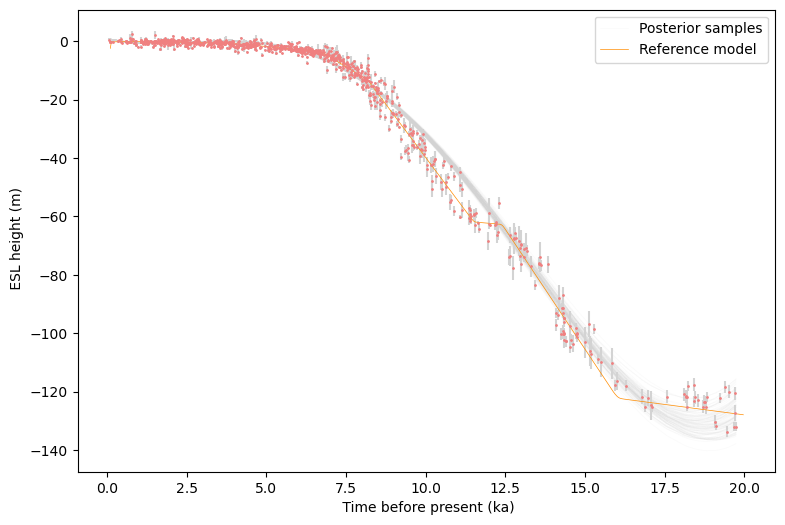

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev25+7.gc214709
numpy 1.21.6
scipy 1.9.1
matplotlib 3.5.3
emcee 3.1.2
arviz 0.12.1
